#**Project 2**
*IE 6400 Foundations Data Analytics Eng*

##**Group 8**

```
1.   Mahrukh Malik
2.   Sumanth Wannur
3.   Gopichand Kandikonda
```

##**Data**

The data used for this project consists of accelerometer data for walking, running, climbing up, and climbing down for all 15 subjects. This data is stored on a Google Drive account accessible through the following link: https://drive.google.com/drive/folders/1UZbuZ4mNjtgIWbggx-OTn3BmGXqeJulq?usp=sharing. The data is organized into 15 folders, each corresponding to a specific subject and labeled as Subject_1, Subject_2, Subject_3, and so on. Within each subject's folder, files are labeled in the format "a_activity_position.csv," such as "acc_climbingdown_chest.csv." An algorithm has been created to process the data and extract relevant information such as activity, position, and subject number, which takes advantage of the data's storage structure.

##**Importing Libraries**

In [ ]:
# install required libraries
!pip install ts2vg
!pip install tabulate
!pip install igraph

In [ ]:
# import required libraries
import os
import numpy as np
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from ts2vg import NaturalVG, HorizontalVG
from tabulate import tabulate

##**Task 1**

###**Key Concepts**
Average Degree: This is a measure of the connectivity of the graph, which is calculated as the average number of edges connected to each node in the graph. It is represented by the formula:
Average Degree = (2 x Number of Edges) / Number of Nodes

Network Diameter: This is the longest shortest path between any two nodes in the graph, and it indicates the maximum number of steps required to reach any other node in the network. It is represented by the formula:
Network Diameter = Max(Shortest Path between all node pairs)

Average Path Length: This is the average of all the shortest paths between any two nodes in the graph. It is represented by the formula:
Average Path Length = (Sum of all Shortest Paths) / (Number of Node Pairs)

###**Defining functions**

We defined **4 functions** to give the required output.



***process_file()***

We have defined a function called process_file to process each data file. The function first reads the CSV file using and creates a DataFrame. It then selects a subset of rows using the DataFrame slicing operator [1000:2024] as required in Task 1. The function then adds columns to the subset DataFrame containing information extracted from the file path and folder name, such as the file name, activity, position, and subject number. Finally, the modified subset DataFrame is returned by the function.

***compute_graph_metrics()***

The function compute_graph_metrics takes in a time series and a method as inputs and computes various metrics on the graph generated from the time series using the specified method. The computed metrics are returned as output of the function.

***process_data()***

The process_data() function takes in an input folder as input and processes all files in the subfolders of the input folder to compute various graph-based metrics on the accelerometer data. The function iterates through all subfolders inside the input folder, and for each subfolder, it obtains the paths of all files in the subfolder, processes each file using the process_file() function, selects the accelerometer data columns, and computes the graph metrics using the compute_graph_metrics() function. The computed metrics are stored in a list of dictionaries, and the list is converted to a pandas dataframe and returned by the function.


***plot_scatterplots()***

This function takes in a pandas dataframe df and a list of activities activities as inputs and plots scatterplots for the average degree and network diameter of the graph metrics based on the accelerometer axis, activity, and method.

In [ ]:
def process_file(file_path):
    
    # Reading CSV file with the given file path using pandas
    # Encoding is set to 'unicode_escape' to handle special characters
    input_data = pd.read_csv(file_path, encoding='unicode_escape')
    
    # Creating a pandas dataframe with the input data
    input_data_df = pd.DataFrame(input_data)

    # Selecting a subset of the input data using row slicing
    subset_df = input_data_df[1000:2024]
    
    # Getting the file name from the file path
    file_name = os.path.basename(file_path)

    # Adding a new temporary column 'File Name' to the subset dataframe and assigning the file name to it
    subset_df['File Name'] = file_name
    
    # Splitting the 'File Name' column into three separate columns using the '_' separator and assigning the split values to columns
    subset_df[['a', 'Activity', 'Position']] = subset_df['File Name'].str.split('_', expand=True)
    subset_df['Position'] = subset_df['Position'].str.replace('.csv', '')
    
    # Extracting the subject number from the parent folder
    subject = os.path.basename(os.path.dirname(file_path)).split('_')[1]
    subset_df['Subject'] = subject
    
    # Returning the processed subset dataframe
    return subset_df

In [77]:
def compute_graph_metrics(time_series, method):

    # Checking the method input and initializing the graph builder accordingly
    if method == 'HVG':
        graph_builder = HorizontalVG()
    elif method == 'NVG':
        graph_builder = NaturalVG()
    else:
        raise ValueError("Invalid method")
        
    # Building the graph using the graph builder and the input time series
    graph_builder.build(time_series)

    # Converting the graph builder output to an igraph object
    graph = graph_builder.as_igraph()
    # Calculating the average degree of the nodes, diameter and average shortest path length of the graph using in-built functions of igraph
    average_degree = np.mean(graph.degree())
    network_diameter = graph.diameter()
    average_path_length = graph.average_path_length()
    
    # Returning the calculated metrics
    return average_degree, network_diameter, average_path_length

In [ ]:
def process_data(input_folder):

    # Initializing an empty list to store the computed metrics
    metrics_data = []

    # Iterating through all subfolders inside the master folder
    for subject_folder in os.listdir(input_folder):
        subject_path = os.path.join(input_folder, subject_folder)
        
        # Skipping non-directory items
        if not os.path.isdir(subject_path):
            continue

        # Obtaining the paths of all files in the subfolder
        file_paths = [os.path.join(subject_path, f) for f in os.listdir(subject_path)]

        # Iterating through all files in the subfolder
        for file_path in file_paths:
            # Processing the file using the 'process_file' function and obtaining a subset dataframe
            subset_df = process_file(file_path)
            # Selecting the accelerometer data columns from the subset dataframe
            accel_df = subset_df.iloc[:, 2:5]

            # Iterating through all methods and all accelerometer axes
            for method in ['HVG', 'NVG']:
                for i in range(len(accel_df.columns)):
                    # Computing the graph metrics
                    average_degree, network_diameter, average_path_length = compute_graph_metrics(accel_df.iloc[:, i], method)

                    # Storing the computed metrics in a dictionary
                    graph_metrics = {
                        'Method': method,
                        'Subject': np.unique(subset_df.Subject)[0],
                        'Accelerometer axis': accel_df.columns[i],
                        'Average degree': average_degree,
                        'Network diameter': network_diameter,
                        'Average path length': average_path_length,
                        'Activity': np.unique(subset_df.Activity)[0],
                        'Position': np.unique(subset_df.Position)[0]
                    }

                    # Appending the computed metrics to the metrics_data list
                    metrics_data.append(graph_metrics)

    # Converting the metrics_data list to a pandas dataframe and returning it
    return pd.DataFrame(metrics_data)

In [ ]:
def plot_scatterplots(df, activities, positions):
  
    # Selecting a subset of the dataframe based on the input list of activities and positions
    position_df = df[df['Position'].isin(positions)]
    activity_df = position_df[position_df['Activity'].isin(activities)]

    # Iterating through each accelerometer axis
    for axis in ['attr_x', 'attr_y', 'attr_z']:
        # Selecting a subset of the dataframe based on the current accelerometer axis
        axis_df = activity_df[activity_df['Accelerometer axis'] == axis]
        
        # Creating a FacetGrid plot with the selected data and customizing its properties
        g = sns.FacetGrid(axis_df, col="Method", hue="Activity", sharey=False, sharex=False, height=6)
        g.map_dataframe(sns.scatterplot, x='Average degree', y='Network diameter')
        g.add_legend()
        
        # Adding a title to the plot
        g.fig.suptitle(f"Accelerometer Axis = {axis}")

        # Displaying the plot
        plt.show()

###**Processing the Data**

In [ ]:
# Mounting the Google Drive and setting the input folder path
drive.mount('/content/drive', force_remount=True)
input_folder = '/content/drive/MyDrive/Project2_Data'

# Calling the 'process_data' function to process the data and compute graph metrics
result_dataframe = process_data(input_folder)

# Performing data cleaning and sorting on resulting dataframe
result_dataframe['Subject'] = pd.to_numeric(result_dataframe['Subject'])
result_dataframe = result_dataframe.sort_values(by=['Subject', 'Activity', 'Position', 'Method']).reset_index(drop=True)

In [ ]:
# Displaying the resulting dataframe
result_dataframe

Method  Subject Accelerometer axis  Average degree  Network diameter  \
0       HVG        1             attr_x        3.951172                32   
1       HVG        1             attr_y        3.947266                28   
2       HVG        1             attr_z        3.968750                23   
3       NVG        1             attr_x       15.609375                16   
4       NVG        1             attr_y       14.087891                10   
...     ...      ...                ...             ...               ...   
2509    HVG       15             attr_y        3.968750                20   
2510    HVG       15             attr_z        3.972656                19   
2511    NVG       15             attr_x       10.216797                14   
2512    NVG       15             attr_y        8.873047                11   
2513    NVG       15             attr_z        9.335938                 9   

      Average path length      Activity Position  
0               14.510884  climbingdown    chest  
1               12.518642  climbingdown    chest  
2                9.949156  climbingdown    chest  
3                6.598815  climbingdown    chest  
4                4.261784  climbingdown    chest  
...                   ...           ...      ...  
2509             9.661313       walking    waist  
2510             9.113724       walking    waist  
2511             4.815265       walking    waist  
2512             5.085678       walking    waist  
2513             4.556343       walking    waist  

[2514 rows x 8 columns]

###**Tabulating Results**

In [84]:
print(tabulate(result_dataframe, headers=result_dataframe.columns, tablefmt='grid', numalign="center", stralign="center", showindex=False))

+----------+-----------+----------------------+------------------+--------------------+-----------------------+--------------+------------+
|  Method  |  Subject  |  Accelerometer axis  |  Average degree  |  Network diameter  |  Average path length  |   Activity   |  Position  |
+==========+===========+======================+==================+====================+=======================+==============+============+
|   HVG    |     1     |        attr_x        |     3.95117      |         32         |        14.5109        | climbingdown |   chest    |
+----------+-----------+----------------------+------------------+--------------------+-----------------------+--------------+------------+
|   HVG    |     1     |        attr_y        |     3.94727      |         28         |        12.5186        | climbingdown |   chest    |
+----------+-----------+----------------------+------------------+--------------------+-----------------------+--------------+------------+
|   HVG    |     1  

###**Generating Scatter Plots**

Extensive research conducted by Pannurat et al. (2017) has demonstrated that the optimal sensor positions for monitoring activities of daily living are the chest and waist, as these positions have been found to have average accuracy values greater than 96%. Accordingly, we have utilized accelerometer readings from these two positions to create scatter plots for our study. This approach ensures that we are using the most effective sensor positions for accurate activity monitoring. The study by Pannurat et al. (2017) provides a strong foundation for our research and supports our conclusion regarding the optimal sensor positions for monitoring activities of daily living.

#####***Citations***
*Pannurat, N., Thiemjarus, S., Nantajeewarawat, E., &amp; Anantavrasilp, I. (2017, April 5). Analysis of optimal sensor positions for activity classification and application on a different data collection scenario. MDPI. Retrieved April 13, 2023, from https://www.mdpi.com/1424-8220/17/4/774*

####**Walking vs Running**

#####**All Sensor Mounting Positions**

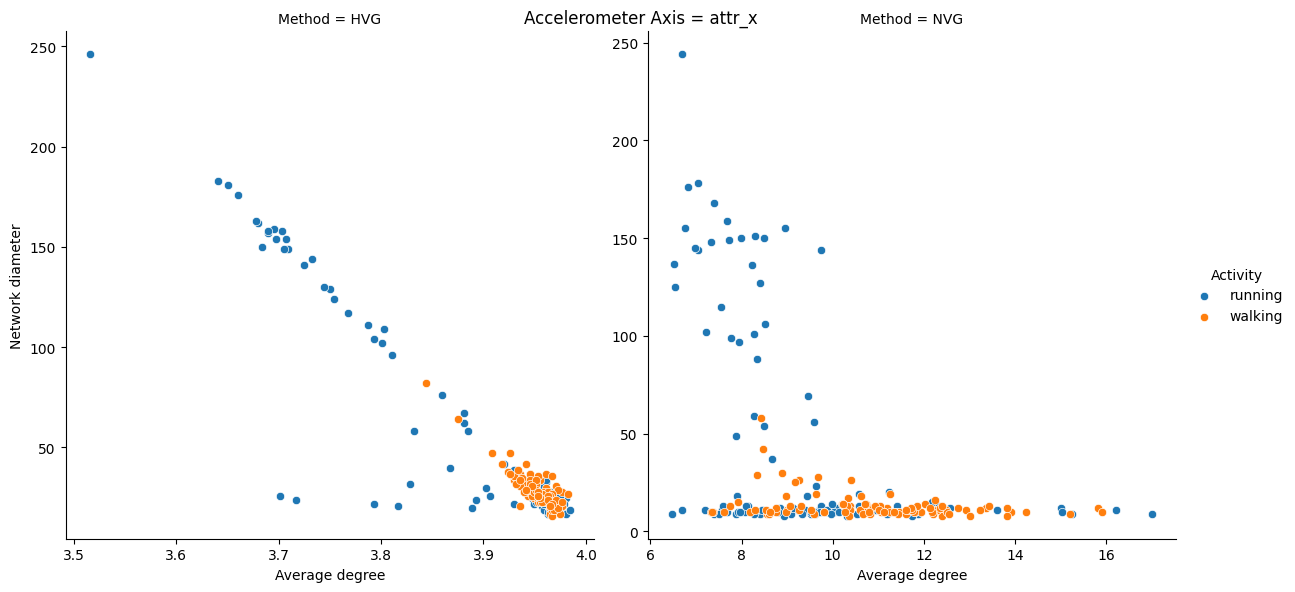

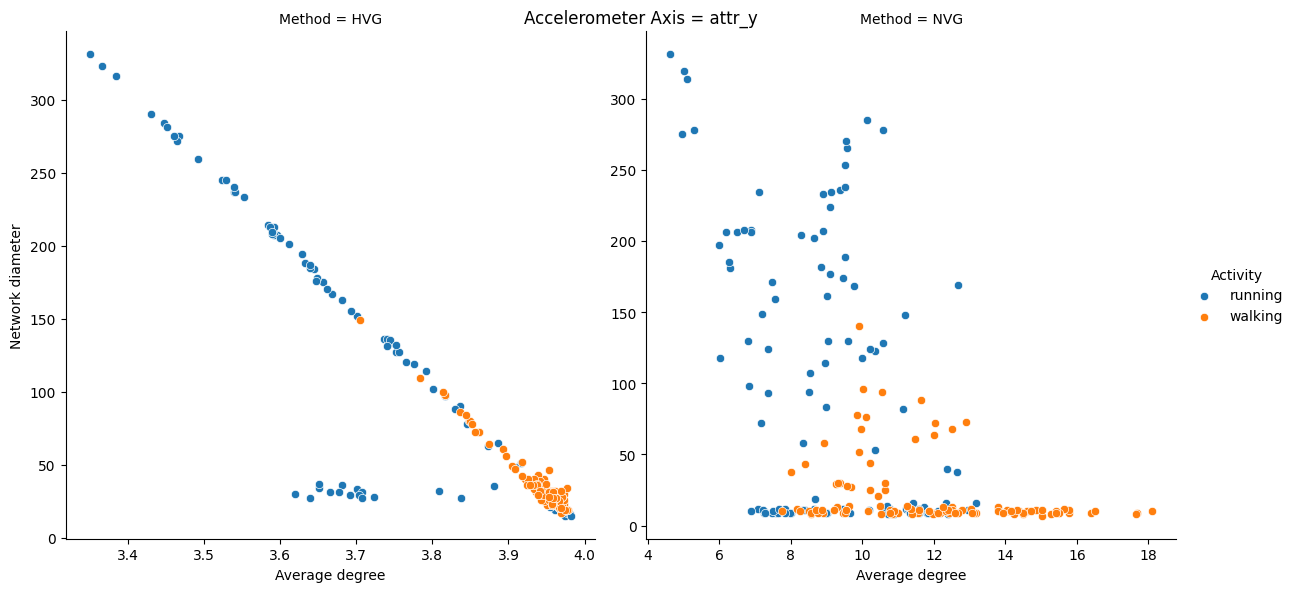

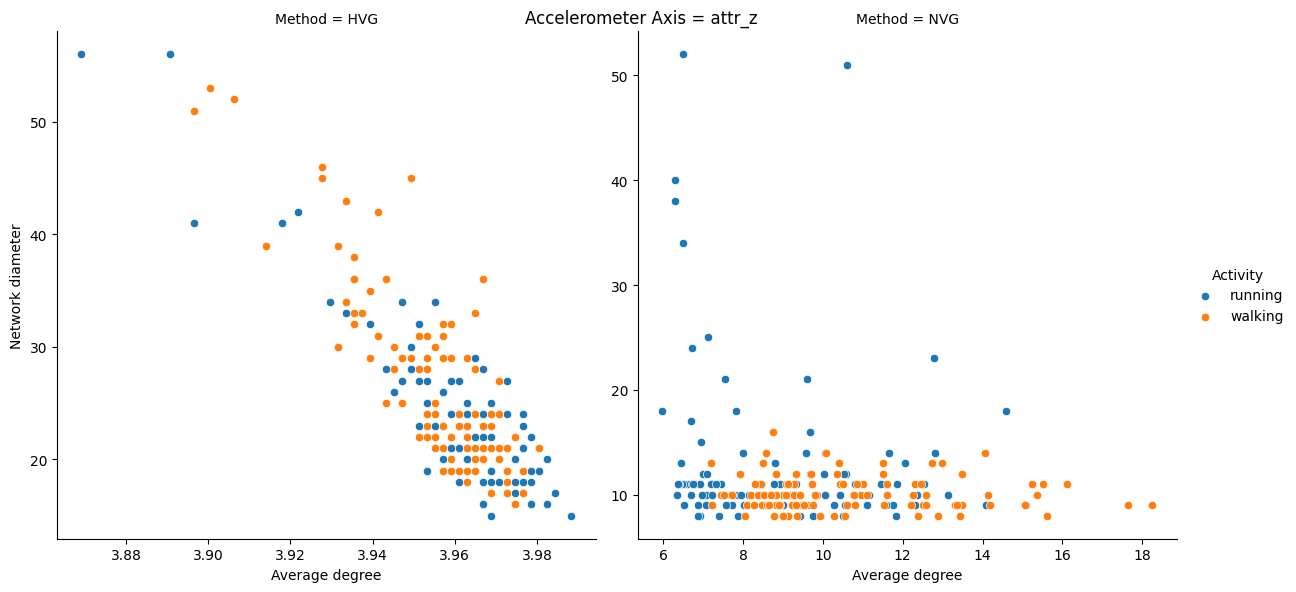

In [ ]:
plot_scatterplots(result_dataframe, ['walking', 'running'], ['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist'])

#####**Optimal Sensor Mounting Positions (Chest & Waist)**

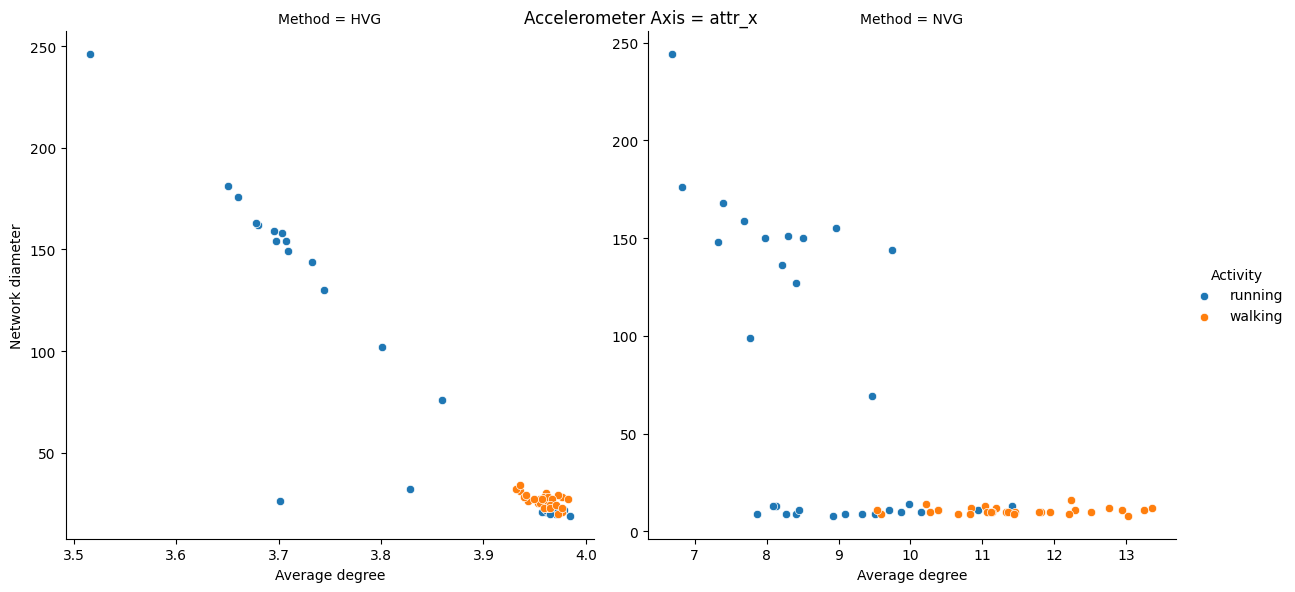

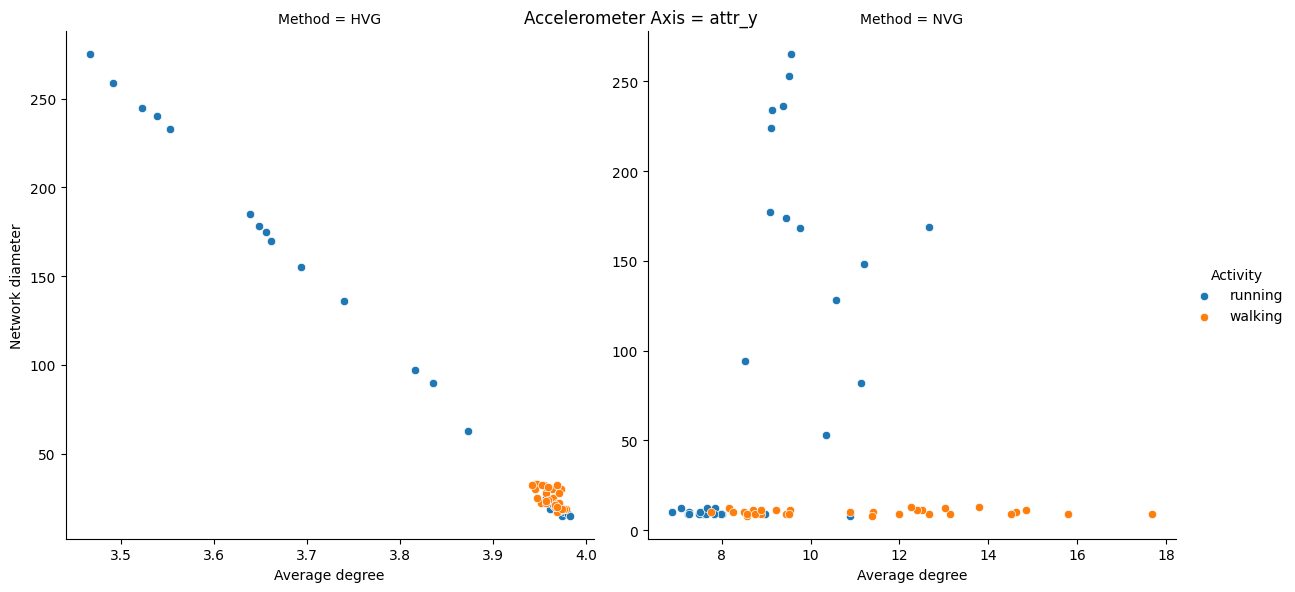

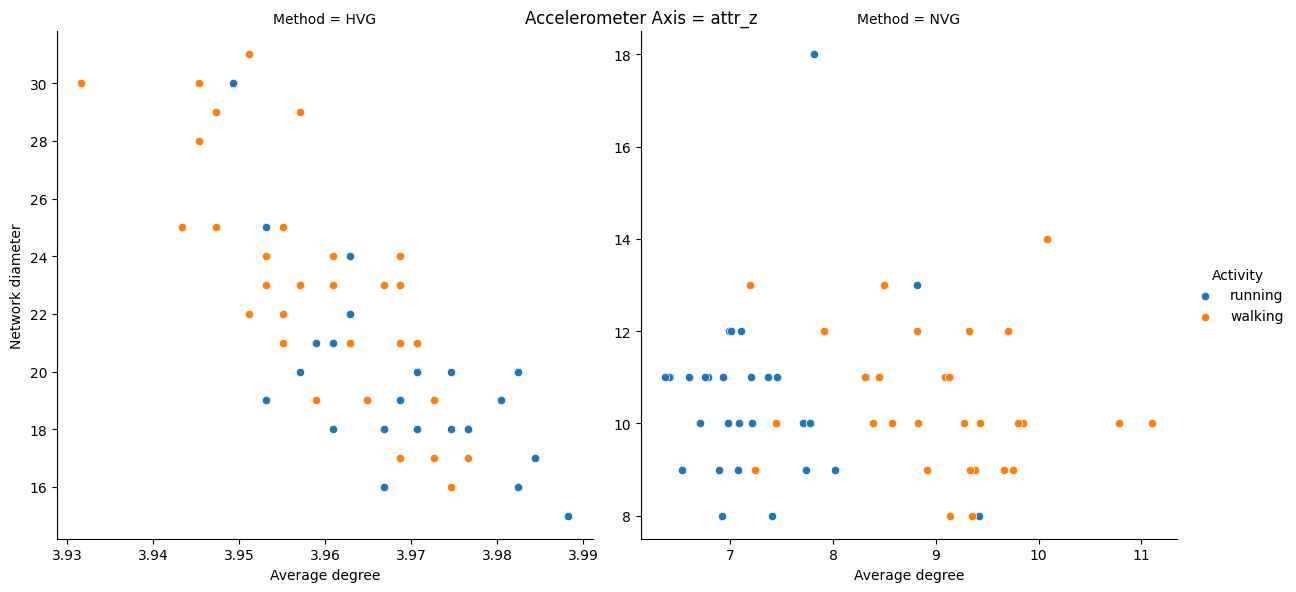

In [ ]:
plot_scatterplots(result_dataframe, ['walking', 'running'], ['chest', 'waist'])

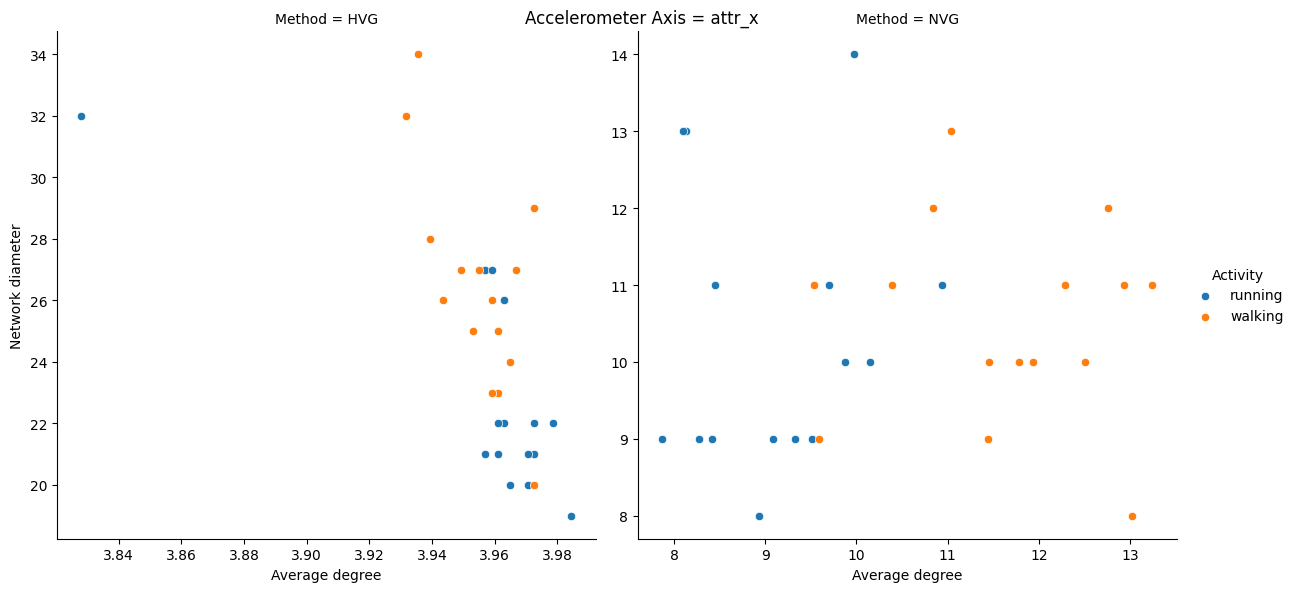

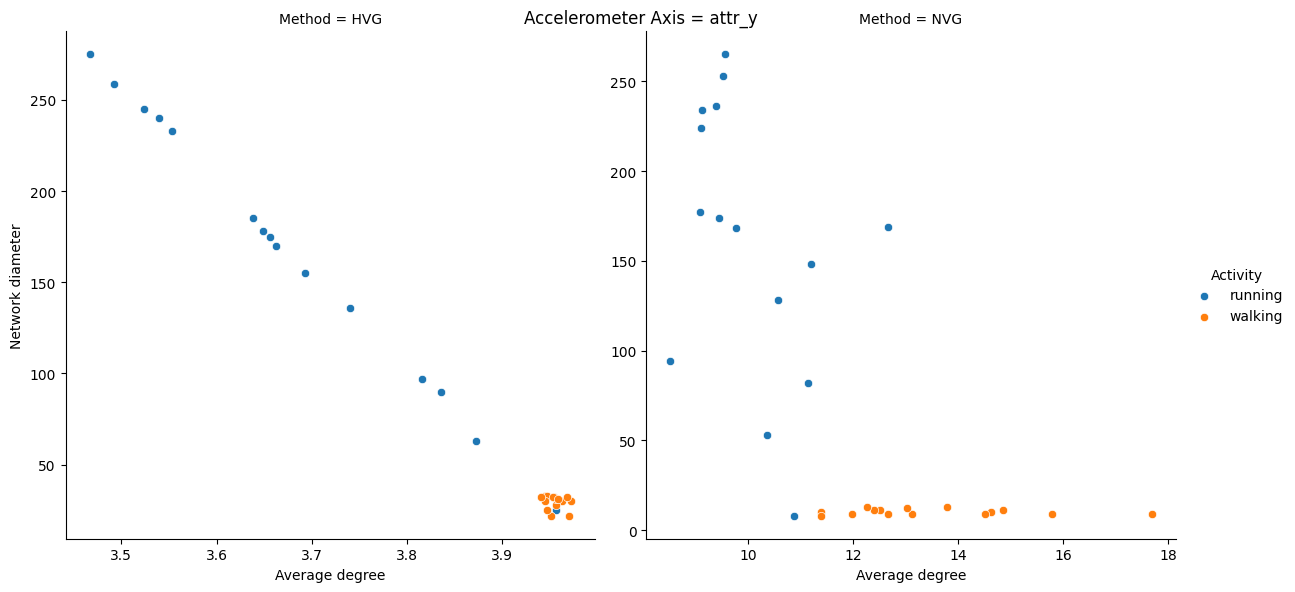

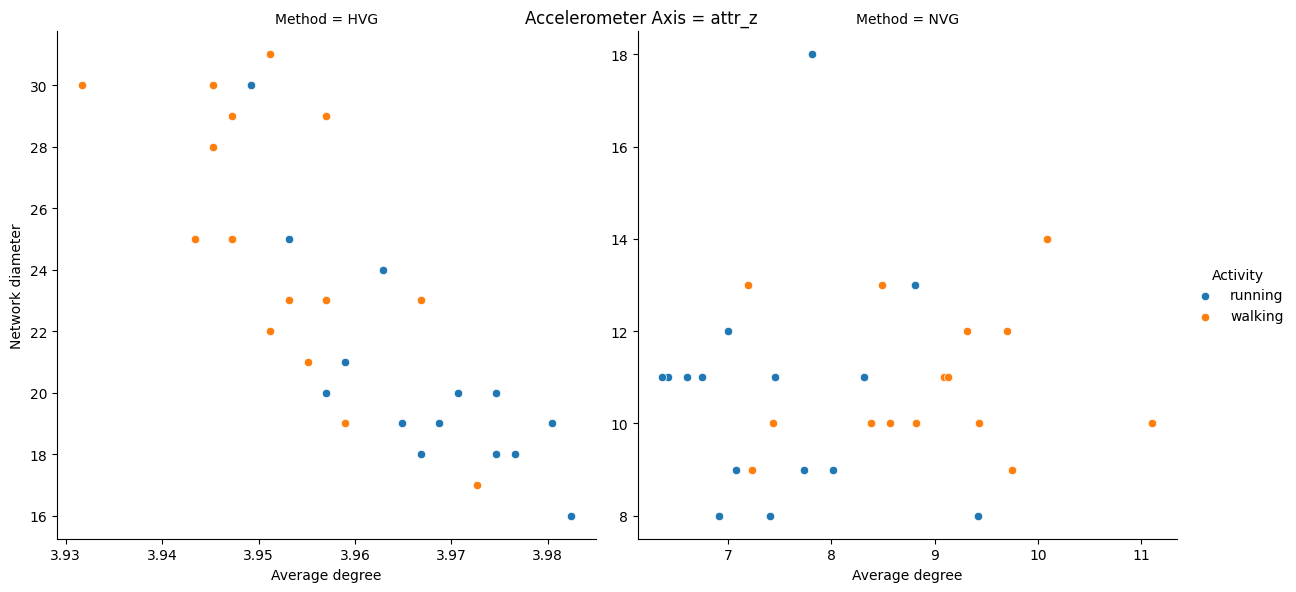

In [ ]:
plot_scatterplots(result_dataframe, ['walking', 'running'], ['chest'])

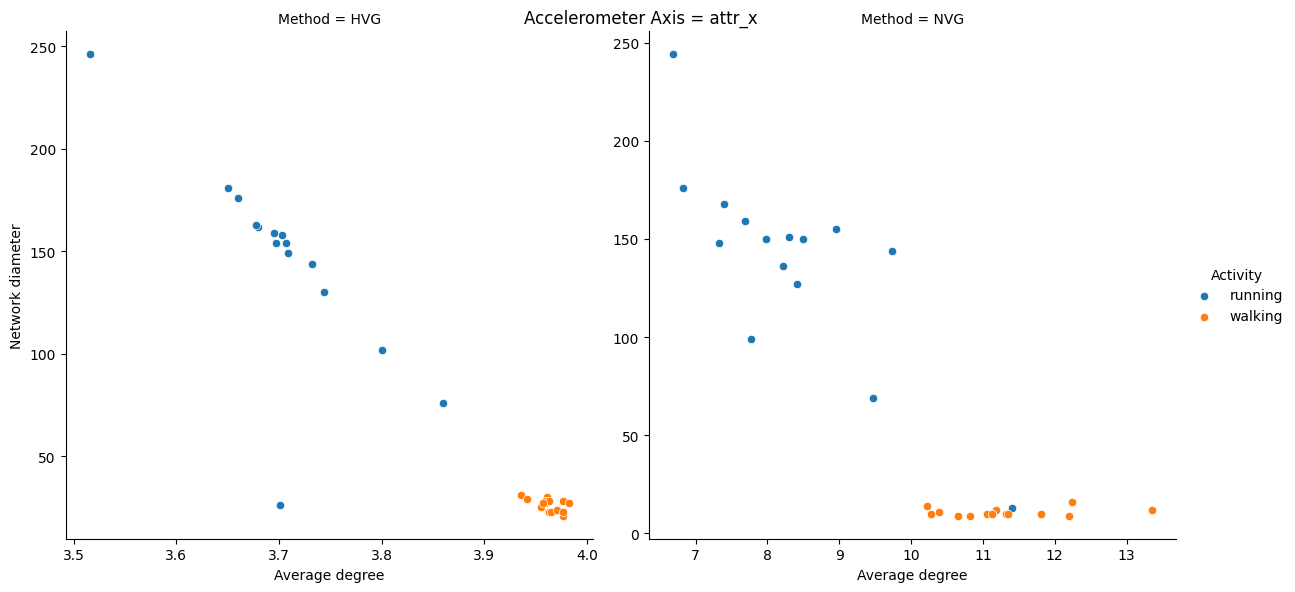

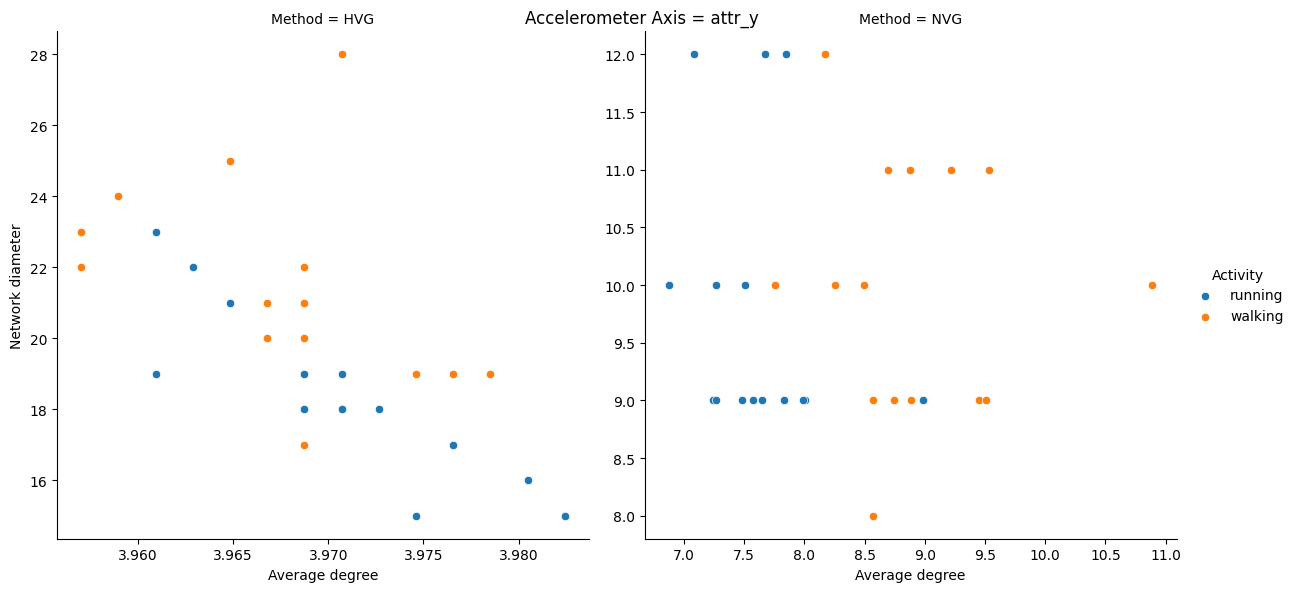

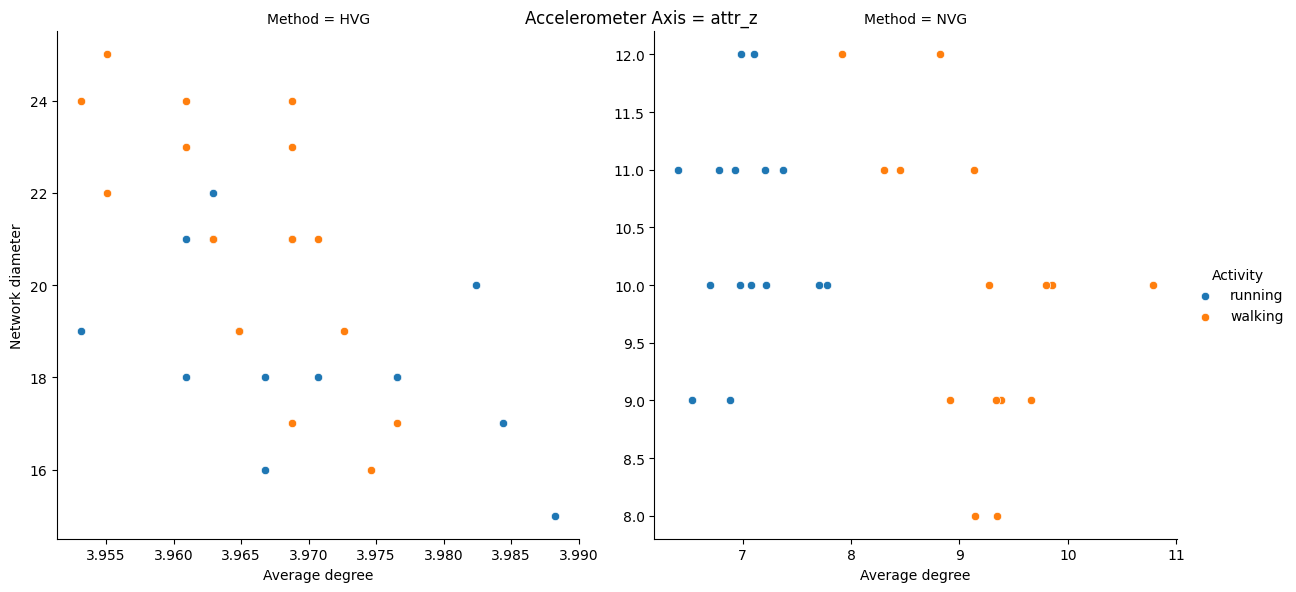

In [ ]:
plot_scatterplots(result_dataframe, ['walking', 'running'], ['waist'])

####**Climbing Up vs Climbing Down**

#####**All Sensor Mounting Positions**

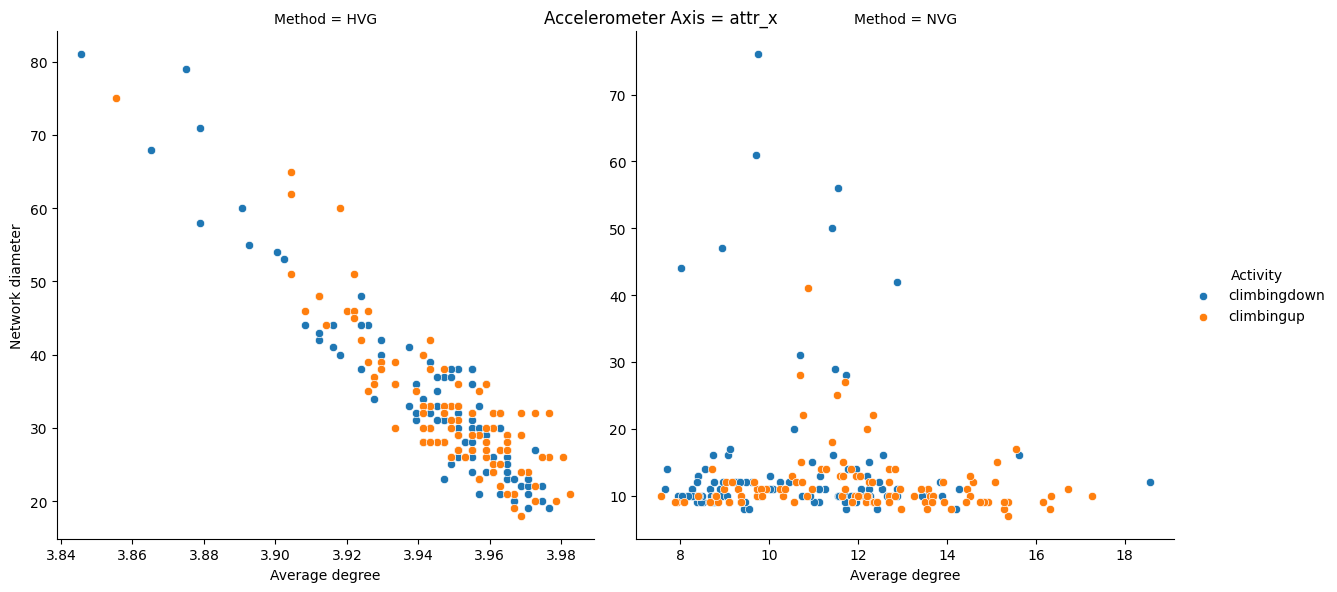

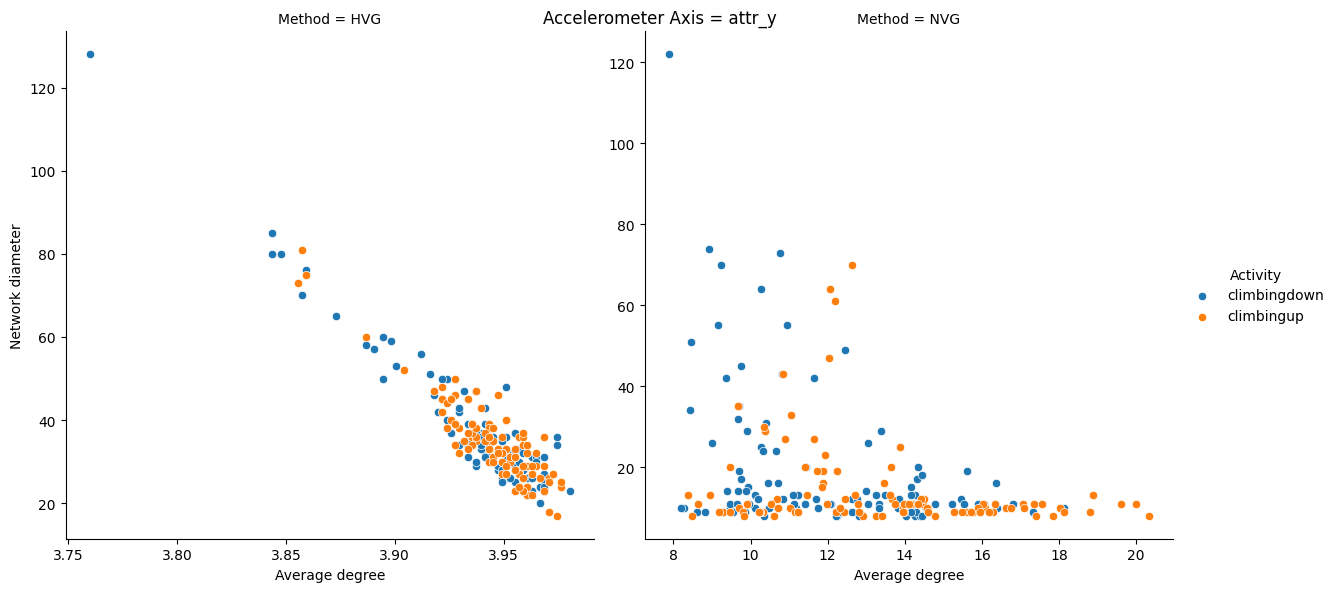

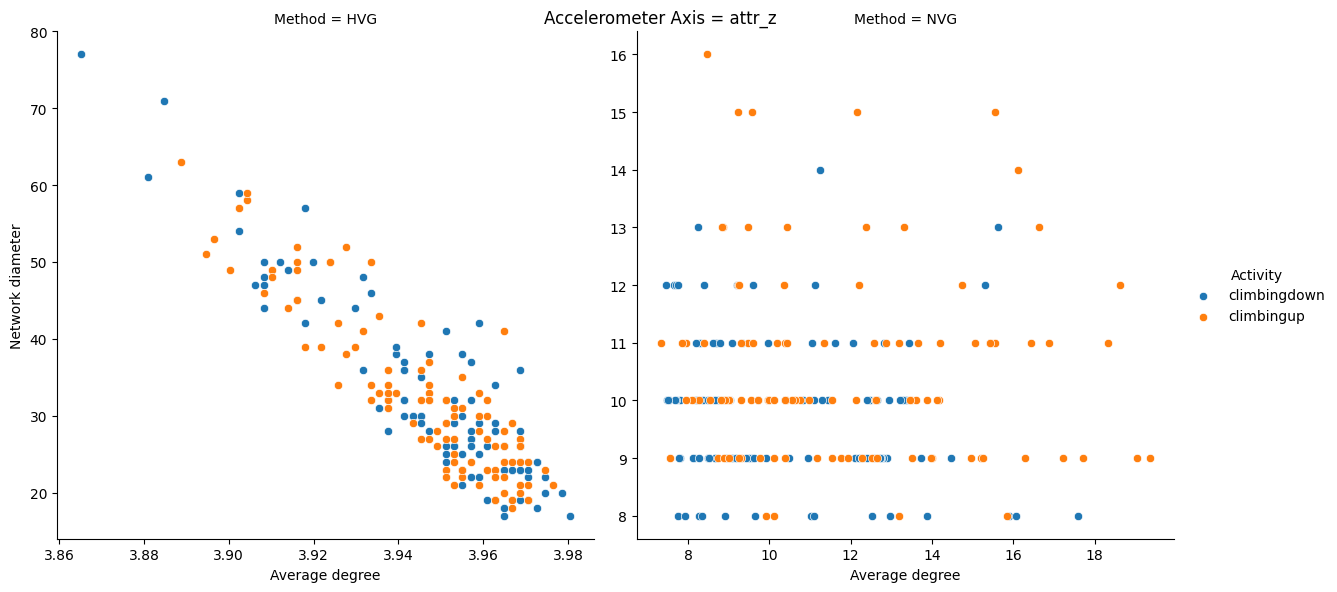

In [ ]:
plot_scatterplots(result_dataframe, ['climbingup', 'climbingdown'], ['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist'])

#####**Optimal Sensor Mounting Positions (Chest & Waist)**

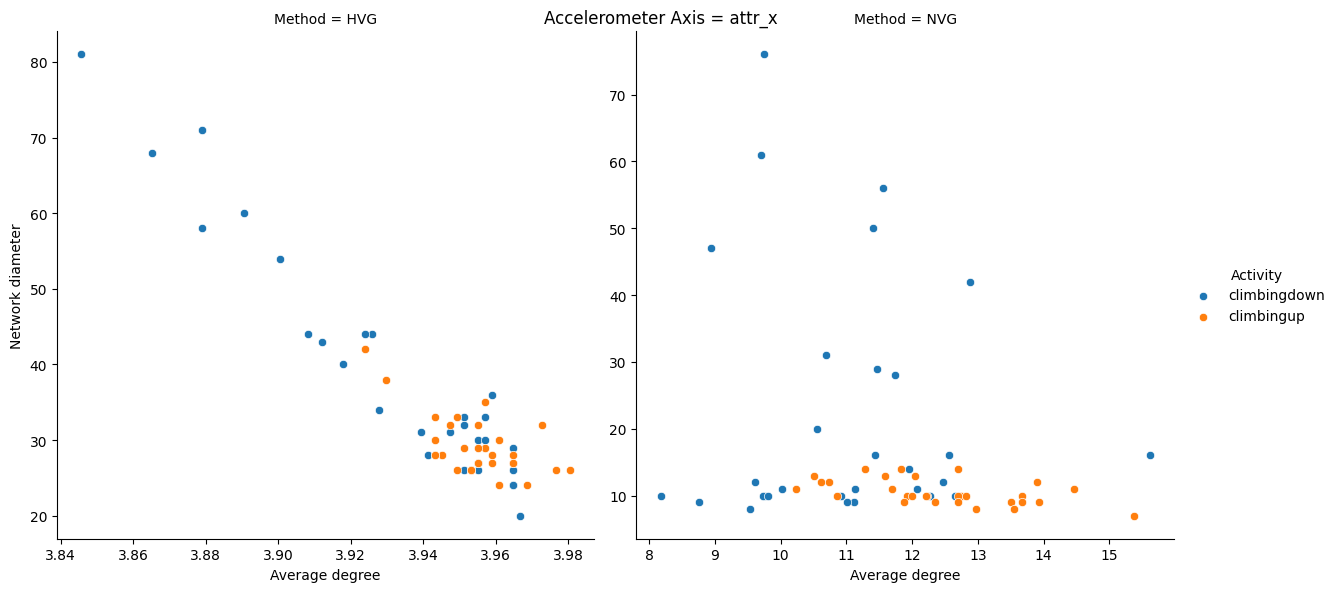

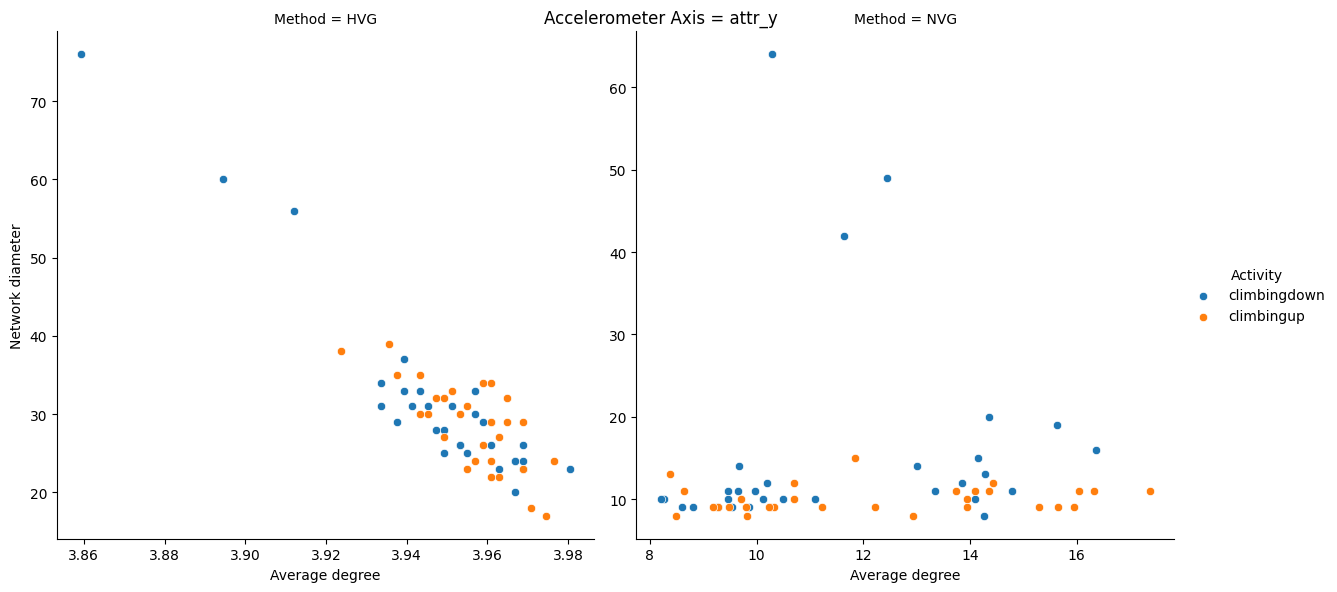

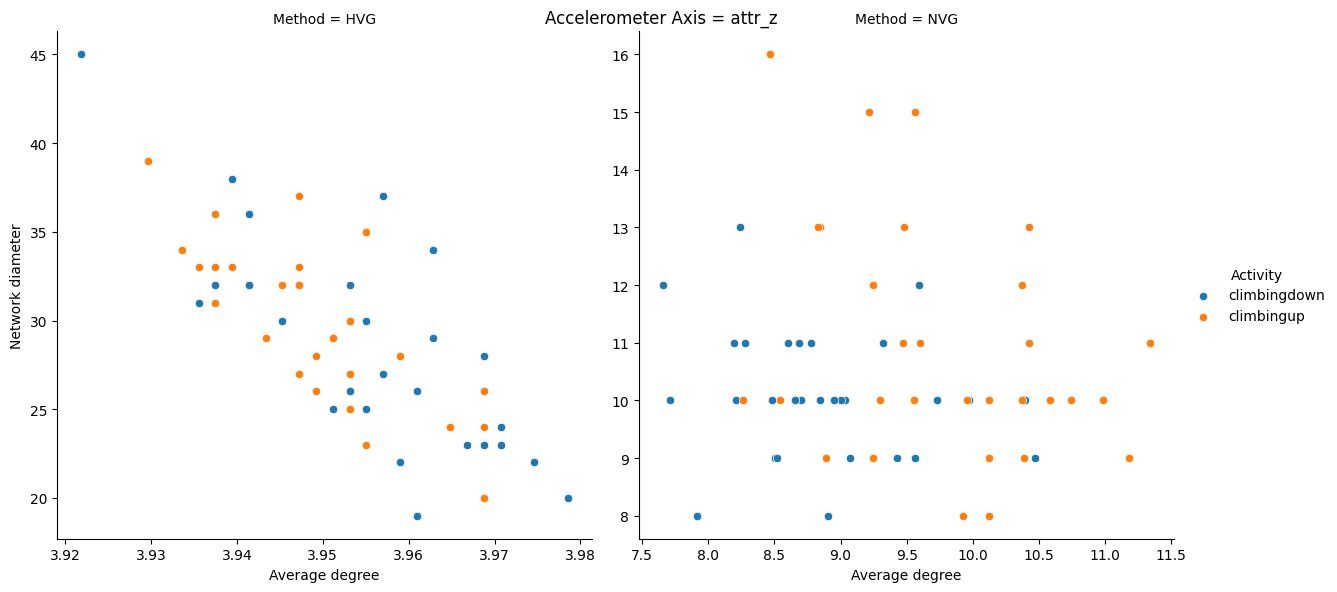

In [ ]:
plot_scatterplots(result_dataframe, ['climbingup', 'climbingdown'], ['chest', 'waist'])

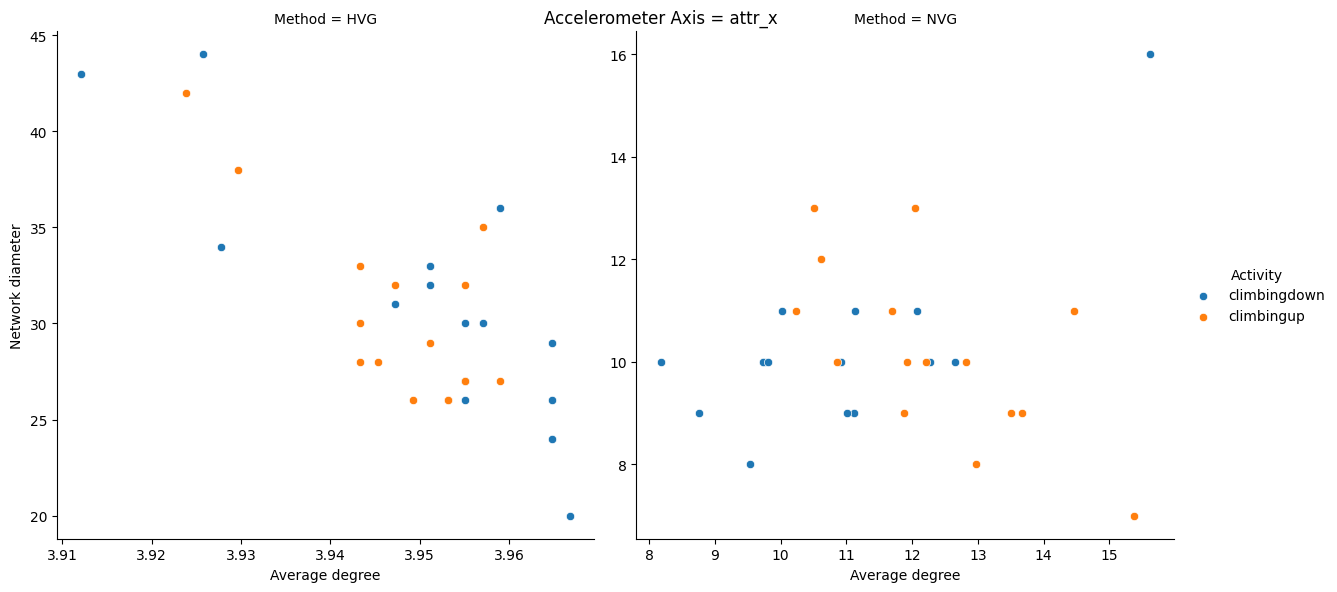

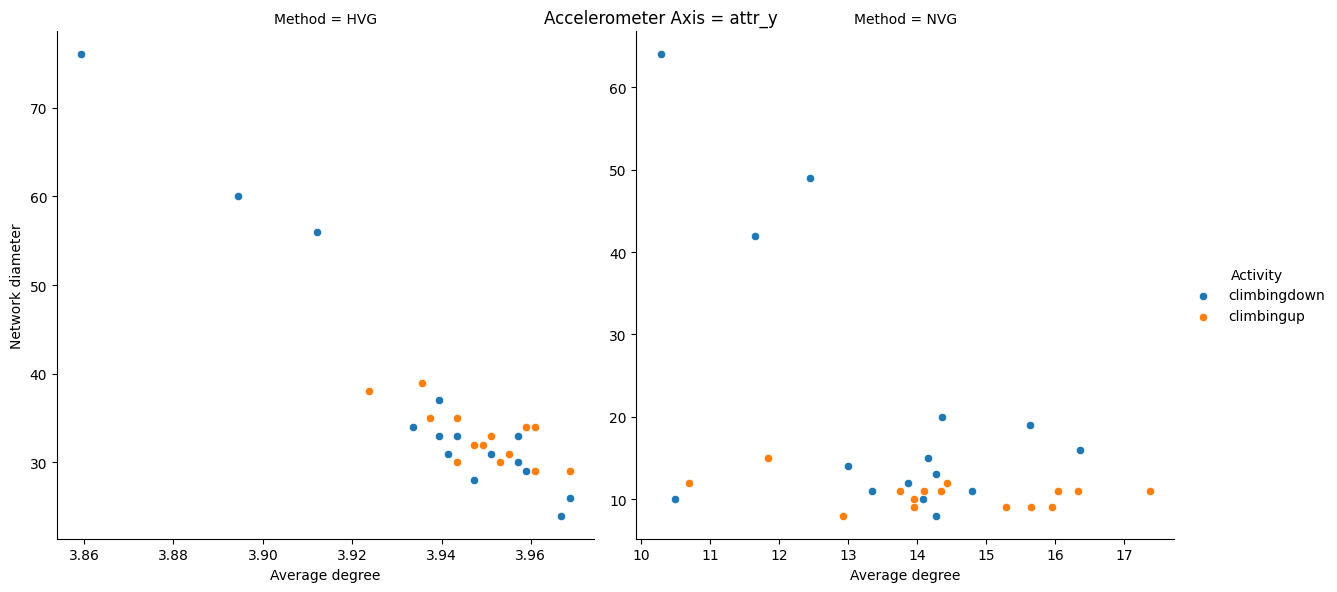

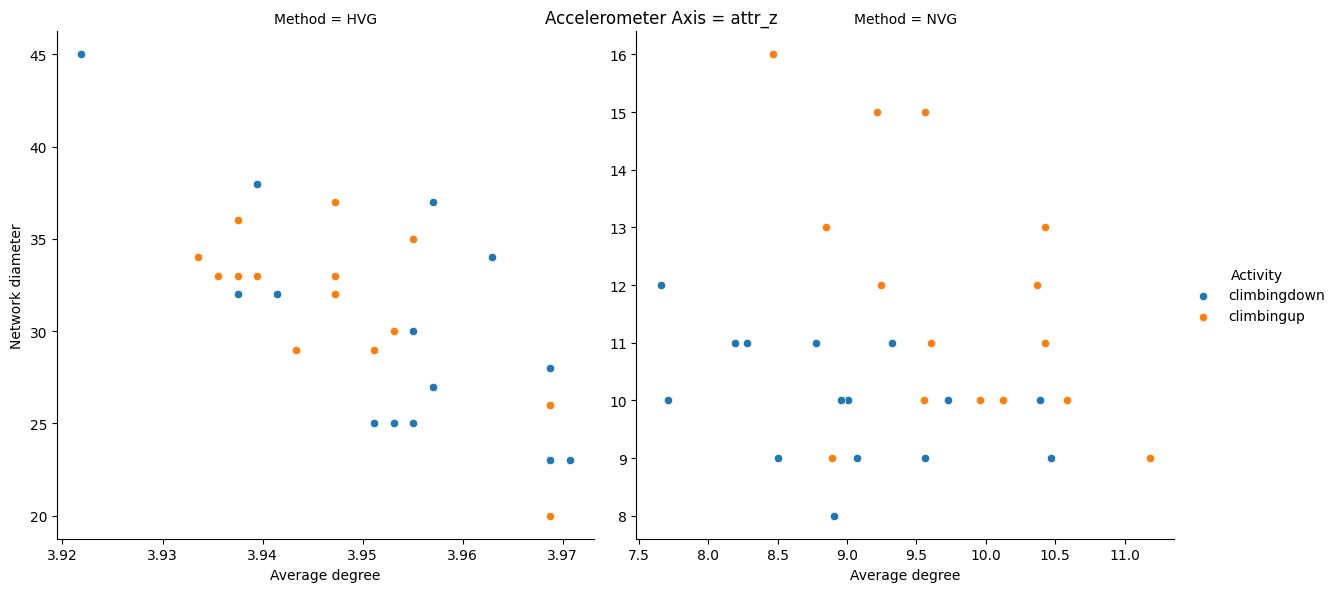

In [ ]:
plot_scatterplots(result_dataframe, ['climbingup', 'climbingdown'], ['chest'])

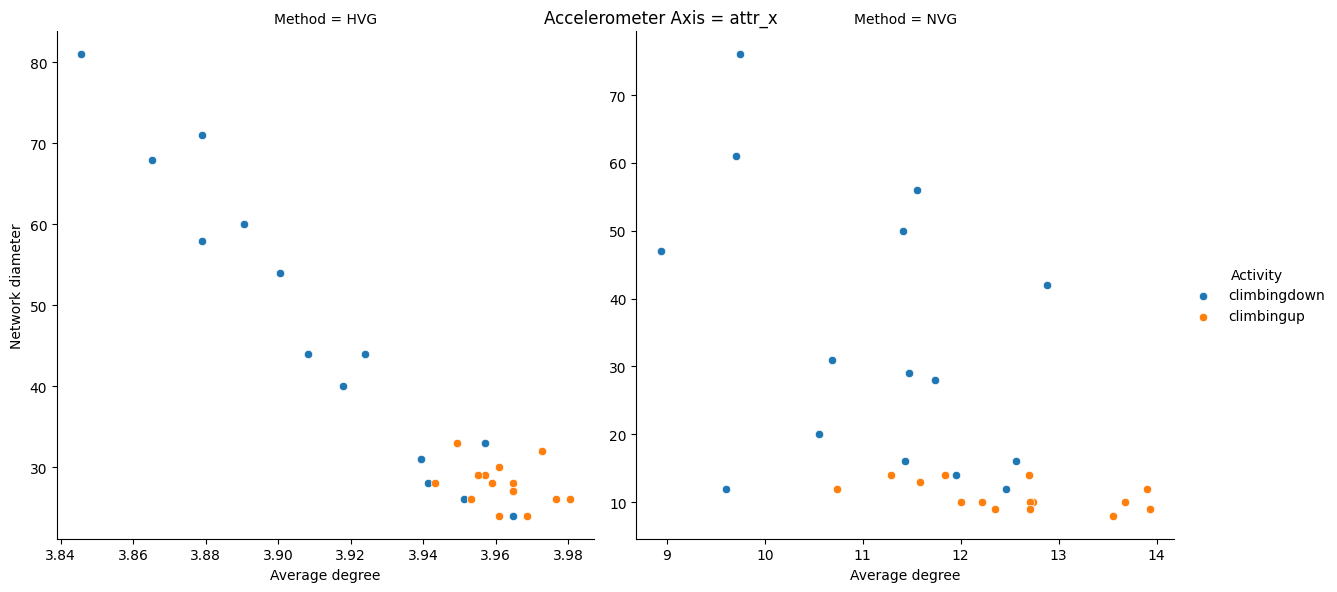

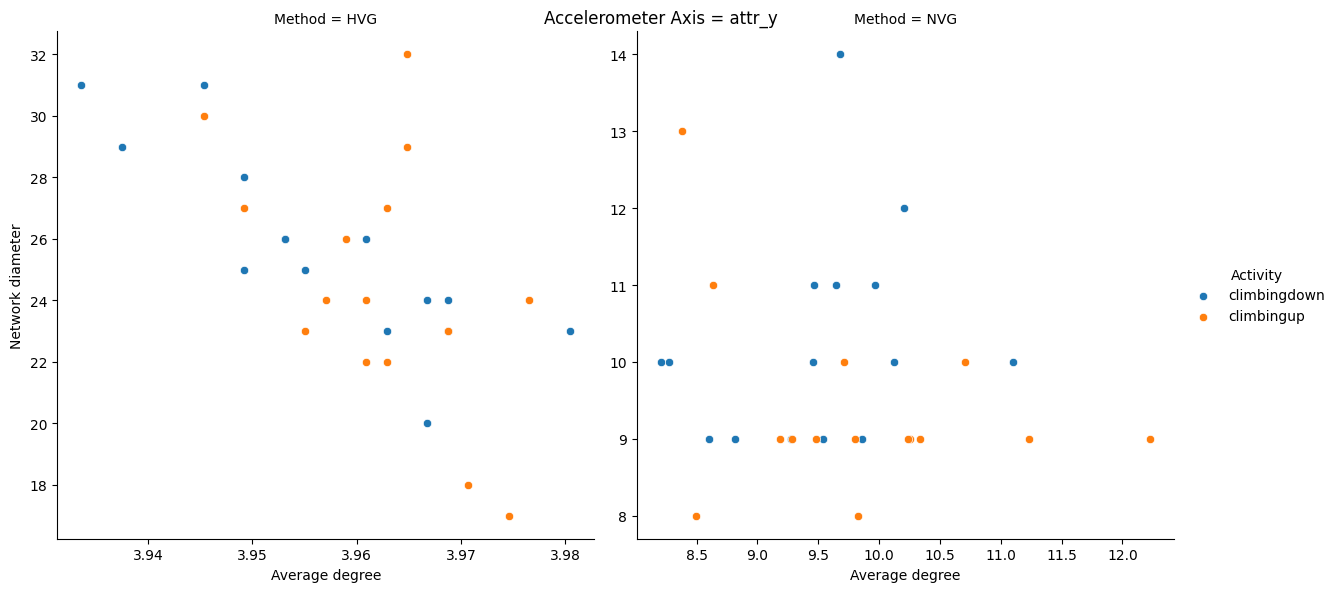

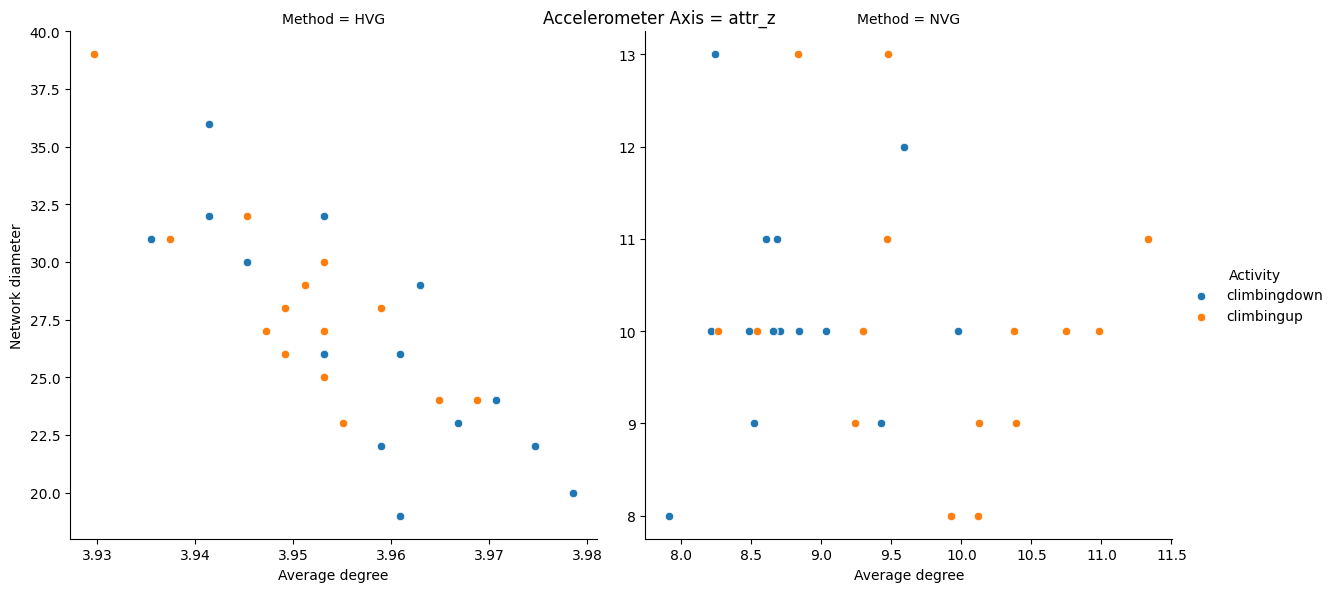

In [ ]:
plot_scatterplots(result_dataframe, ['climbingup', 'climbingdown'], ['waist'])

##**Task 2**

###**Key Concepts**
Permutation Entropy: This is a measure of the complexity of the time series data, which quantifies the amount of uncertainty in the order of the data points. It is calculated by dividing the number of distinct patterns (permutations) by the total number of patterns for a given embedding dimension and time delay. It is represented by the formula:
PE = -Σ(p_i)log(p_i)
where p_i is the probability of occurrence of each distinct permutation.

Permutation Complexity: This is another measure of the complexity of the time series data, which quantifies the degree of irregularity and randomness in the data. It is calculated by counting the number of distinct permutations that occur in the time series data for a given embedding dimension and time delay. It is represented by the formula:
PC = N! / Π(n_i!)

###**Defining functions**

For this task, we have used the functions developed by srk-srinivasan and are described in a GitHub repository called "Permutation-Entropy", to calculate permutation entropy and complexity of a given time series.

In addition to that, we have defined **4 functions** to read data and give the required output.


***process_file()***

We have defined a function called process_file to process each data file. The function first reads the CSV file using and creates a DataFrame. The function then adds columns to the subset DataFrame containing information extracted from the file path and folder name, such as the file name, activity, position, and subject number. Finally, the modified subset DataFrame is returned by the function.

***compute_permutation_entropy_complexity()***

The compute_permutation_entropy_complexity() function is used to calculate the permutation entropy and complexity values for a given time series represented by the signal parameter. The function takes the embedding dimension 'dimension' and embedding delay 'delay' as input parameters along with signal. It first calculates the ordinal patterns for the input time series using the ordinal_patterns() function. The function then calculates the permutation entropy and complexity of the ordinal patterns using the p_entropy() and complexity() functions respectively. Finally, the function returns the permutation entropy and complexity as a tuple.

***process_data_task2()***

The process_data_task2() function processes data from a specified input folder. The function iterates through all subfolders inside the master folder and obtains the paths of all files in each subfolder. It processes each file using the process_file() function and extracts the accelerometer data columns from the subset dataframe. The function then loops through each possible combination of Accelerometer, Dimension, Delay, and Signal, extracts the signal for the current combination, calculates the permutation entropy and complexity for the signal, and adds the processed data to a list. Finally, the list is converted to a pandas dataframe and returned. Overall, the process_data_task2() function processes data from multiple files and returns a dataframe containing information on the permutation entropy and complexity for different combinations of accelerometer data and other parameters.

***plot_task2_scatterplots()***

This function takes in a pandas dataframe df and a list of activities activities as inputs and subsets the dataframe to include only Signal Length 4096 and Delay 1. The function then plots scatterplots for the permutation entropy and complexity of accelerometer axis.

In [61]:
'''The techniques used for calculating permutation entropy were obtained from
a GitHub repository called "Permutation-Entropy" (https://github.com/srk-srinivasan/Permutation-Entropy).
Credit goes to srk-srinivasan for these methods.'''


def s_entropy(freq_list):
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :] 
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 
    

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :] 
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0]) 

In [62]:
def process_file(file_path):
  
    # Reading CSV file with the given file path using pandas
    # Encoding is set to 'unicode_escape' to handle special characters
    input_data = pd.read_csv(file_path, encoding='unicode_escape')

    # Creating a pandas dataframe with the input data
    input_data_df = pd.DataFrame(input_data)
    
    # Getting the file name from the file path
    file_name = os.path.basename(file_path)

    # Adding a new temporary column 'File Name' to the subset dataframe and assigning the file name to it
    input_data_df['File Name'] = file_name
    
    # Splitting the 'File Name' column into three separate columns using the '_' separator and assigning the split values to columns
    input_data_df[['a', 'Activity', 'Position']] = input_data_df['File Name'].str.split('_', expand=True)
    input_data_df['Position'] = input_data_df['Position'].str.replace('.csv', '')
    
    # Extracting the subject number from the parent folder
    subject = os.path.basename(os.path.dirname(file_path)).split('_')[1]
    input_data_df['Subject'] = subject
    
    # Returning the processed subset dataframe
    return input_data_df

In [ ]:
def compute_permutation_entropy_complexity(signal, dimension, delay):
    
    # Calculating the ordinal patterns for the given signal, dimension, and delay values
    op = ordinal_patterns(signal, dimension, delay)
    
    # Calculating the permutation entropy of the ordinal patterns
    pe = p_entropy(op)

    # Calculating the complexity of the ordinal patterns
    complexity_value = complexity(op)

    # Returning the permutation entropy and complexity as a tuple
    return pe, complexity_value

In [63]:
def process_data_task2(input_folder):

    # Initializing an empty list to store the processed data
    task2_data = []

    # Iterating through all subfolders inside the master folder
    for subject_folder in os.listdir(input_folder):
        subject_path = os.path.join(input_folder, subject_folder)

        # Skipping non-directory items
        if not os.path.isdir(subject_path):
            continue

        # Obtaining the paths of all files in the subfolder
        file_paths = [os.path.join(subject_path, f) for f in os.listdir(subject_path)]

        # Iterating through all files in the subfolder
        for file_path in file_paths:
            # Processing the file using the 'process_file' function and obtaining a subset dataframe
            subset_df = process_file(file_path)
            # Selecting the accelerometer data columns from the subset dataframe
            accel_df = subset_df.iloc[:, 2:5]

            # Looping through each possible combination of Accelerometer, Dimension, Delay, and Signal
            for Accelerometer in ['attr_x', 'attr_y', 'attr_z']:
                for Dimension in np.array([3, 4, 5, 6]):
                    for Delay in np.array([1, 2, 3]):
                        for Signal in np.array([1024, 2048, 4096]):
                            # Extracting the signal for the current combination of Accelerometer, Dimension, Delay, and Signal
                            signal = accel_df[Accelerometer][0:Signal]
                            # Calculating permutation entropy and complexity for the current signal and combination of parameters
                            pe, complexity_value = compute_permutation_entropy_complexity(signal, Dimension, Delay)

                            # Adding the processed data to the task2_data list
                            task2_data.append({
                                'Subject': np.unique(subset_df.Subject)[0],
                                'Accelerometer Axis': Accelerometer,
                                'Signal Length': Signal,
                                'Dimension': Dimension,
                                'Delay': Delay,
                                'Permutation Entropy': pe, 
                                'Complexity': complexity_value, 
                                'Activity': np.unique(subset_df.Activity)[0],
                                'Position': np.unique(subset_df.Position)[0]
                            })

    # Converting the task2_data list to a pandas dataframe and returning it
    return pd.DataFrame(task2_data)

In [68]:
def plot_task2_scatterplots(df, activities, positions):

    # Selecting a subset of the dataframe based on the input list of activities
    position_df = df[df['Position'].isin(positions)]
    activity_df = position_df[position_df['Activity'].isin(activities)]

    # Subsetting the dataframe to include only Signal Length 4096
    activity_df = activity_df[activity_df['Signal Length'] == 4096]

    # Subsetting the dataframe to include only Delay 1
    activity_df = activity_df[activity_df['Delay'] == 1]

    # Iterating through each accelerometer axis
    for axis in ['attr_x', 'attr_y', 'attr_z']:
        # Selecting a subset of the dataframe based on the current accelerometer axis
        axis_df = activity_df[activity_df['Accelerometer Axis'] == axis]
        
        # Creating a FacetGrid plot with the selected data and customizing its properties
        g = sns.FacetGrid(axis_df, col="Dimension", hue="Activity", sharey=False, sharex=False, height=8)
        g.map_dataframe(sns.scatterplot, x='Permutation Entropy', y='Complexity')
        g.add_legend()
        
        # Adding a title to the plot
        for ax in g.axes.flat:
            dim = ax.get_title().split(" = ")[1]
            ax.set_title(f"Dimension = {dim} | Accelerometer Axis = {axis}")

        # Displaying the plot
        plt.show()

###**Processing the Data**

In [ ]:
# Mounting the Google Drive and setting the input folder path
drive.mount('/content/drive', force_remount=True)
input_folder = '/content/drive/MyDrive/Project2_Data'

# Calling the 'process_data_task2' function to process the data and compute permutation entropy and complexity
task2_dataframe = process_data_task2(input_folder)

# Performing data cleaning and sorting on resulting dataframe
task2_dataframe['Subject'] = pd.to_numeric(task2_dataframe['Subject'])
task2_dataframe = task2_dataframe.sort_values(by=['Subject', 'Activity', 'Position', 'Dimension', 'Delay', 'Signal Length']).reset_index(drop=True)

In [65]:
# Displaying the resulting dataframe
task2_dataframe

Subject Accelerometer Axis  Signal Length  Dimension  Delay  \
0            1             attr_x           1024          3      1   
1            1             attr_y           1024          3      1   
2            1             attr_z           1024          3      1   
3            1             attr_x           2048          3      1   
4            1             attr_y           2048          3      1   
...        ...                ...            ...        ...    ...   
45247       15             attr_y           2048          6      3   
45248       15             attr_z           2048          6      3   
45249       15             attr_x           4096          6      3   
45250       15             attr_y           4096          6      3   
45251       15             attr_z           4096          6      3   

       Permutation Entropy  Complexity      Activity Position  
0                 0.863880    0.113789  climbingdown    chest  
1                 0.871156    0.109263  climbingdown    chest  
2                 0.866439    0.112078  climbingdown    chest  
3                 0.815191    0.147157  climbingdown    chest  
4                 0.832828    0.135846  climbingdown    chest  
...                    ...         ...           ...      ...  
45247             0.957319    0.092265       walking    waist  
45248             0.908579    0.164538       walking    waist  
45249             0.882068    0.212229       walking    waist  
45250             0.948479    0.112843       walking    waist  
45251             0.871897    0.224367       walking    waist  

[45252 rows x 9 columns]

###**Tabulating Results**

In [83]:
%config NotebookApp.iopub_data_rate_limit=1000000000
print(tabulate(task2_dataframe.head(100), headers=task2_dataframe.columns, tablefmt='grid', numalign="center", stralign="center", showindex=False))

+-----------+----------------------+-----------------+-------------+---------+-----------------------+--------------+--------------+------------+
|  Subject  |  Accelerometer Axis  |  Signal Length  |  Dimension  |  Delay  |  Permutation Entropy  |  Complexity  |   Activity   |  Position  |
+===========+======================+=================+=============+=========+=======================+==============+==============+============+
|     1     |        attr_x        |      1024       |      3      |    1    |        0.86388        |   0.113789   | climbingdown |   chest    |
+-----------+----------------------+-----------------+-------------+---------+-----------------------+--------------+--------------+------------+
|     1     |        attr_y        |      1024       |      3      |    1    |       0.871156        |   0.109263   | climbingdown |   chest    |
+-----------+----------------------+-----------------+-------------+---------+-----------------------+--------------+-------

###**Generating Scatter Plots**

####**Walking vs Running**

#####**All Sensor Mounting Positions**

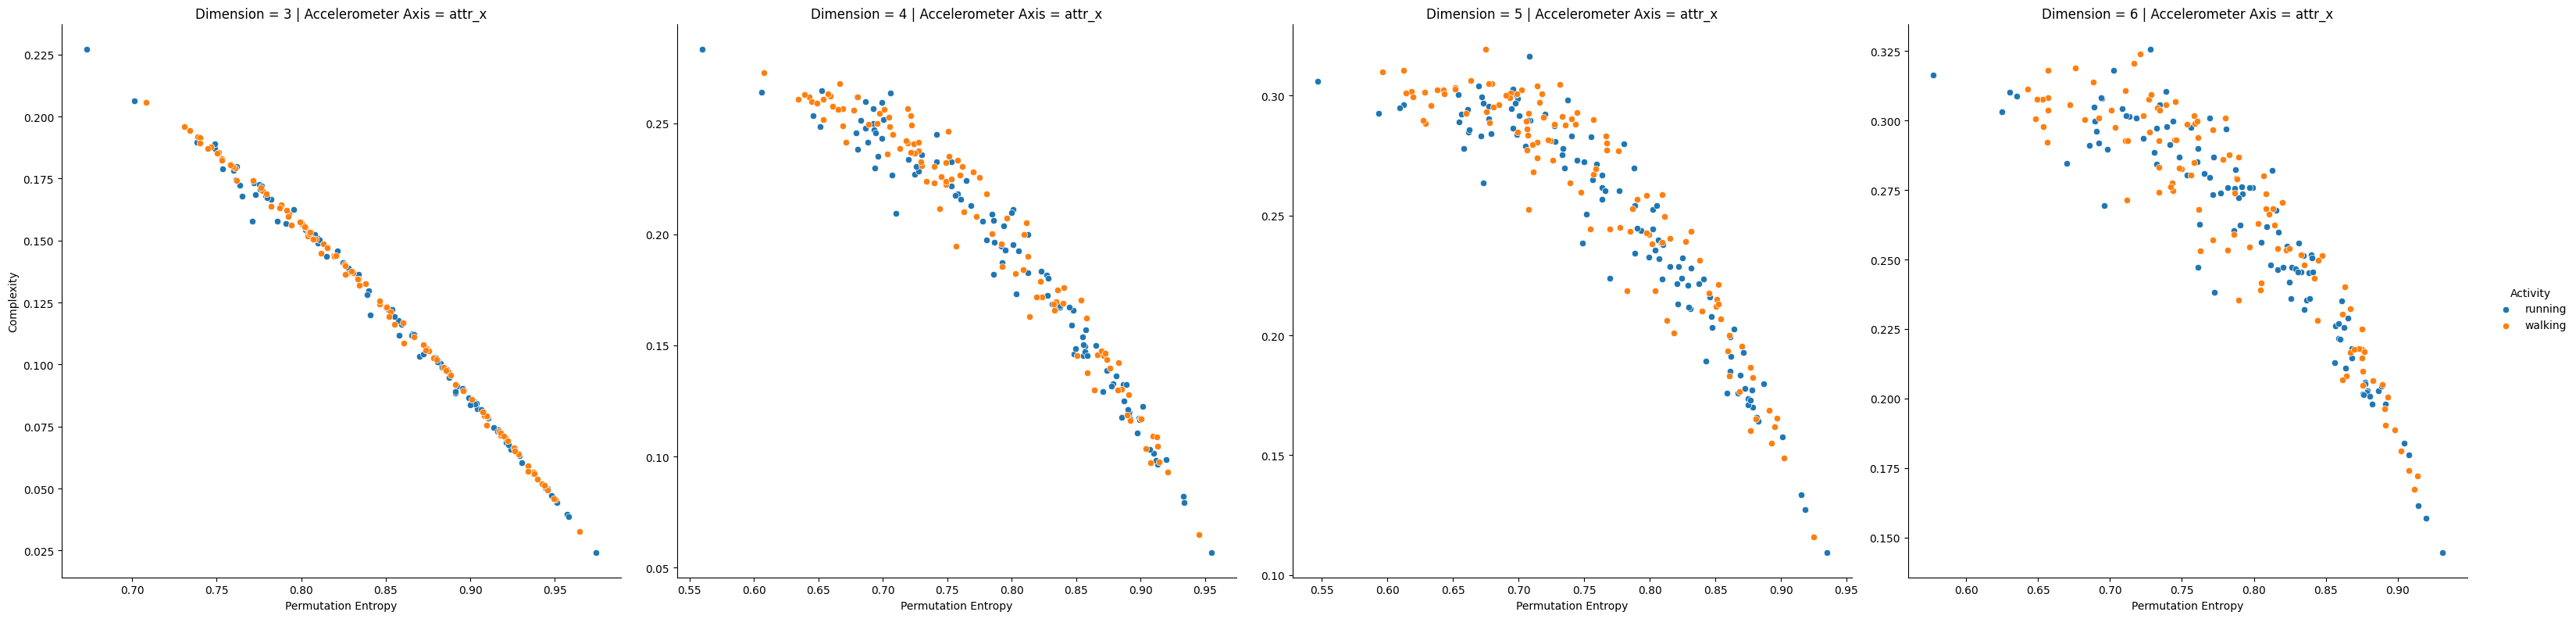

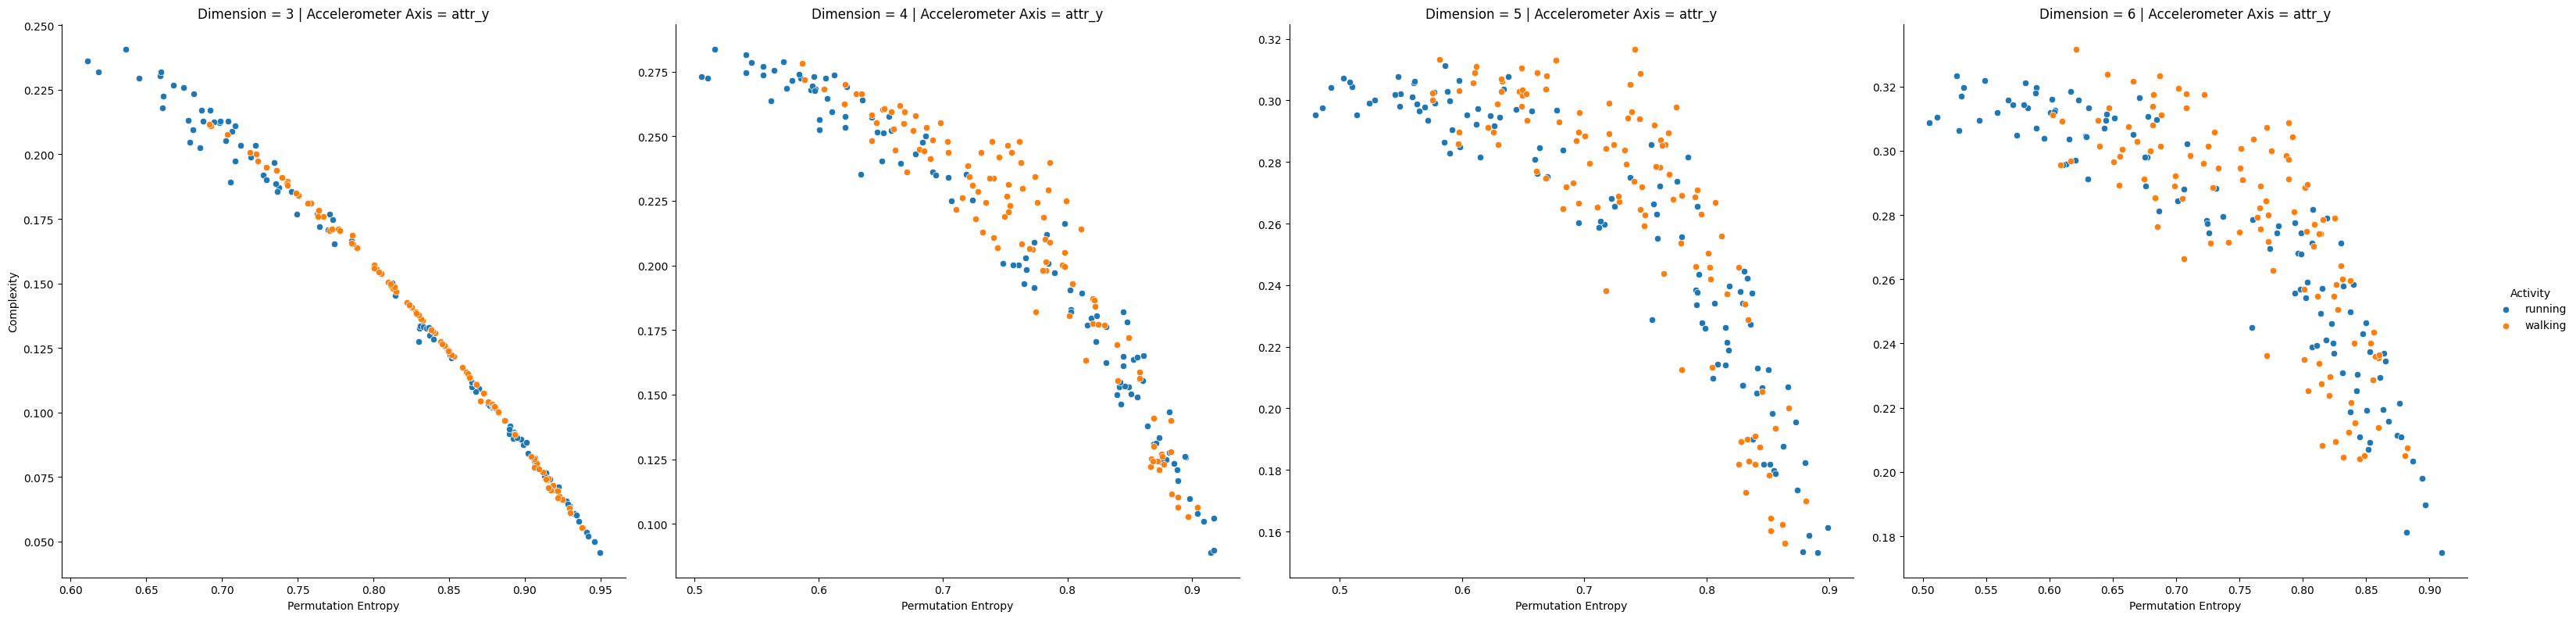

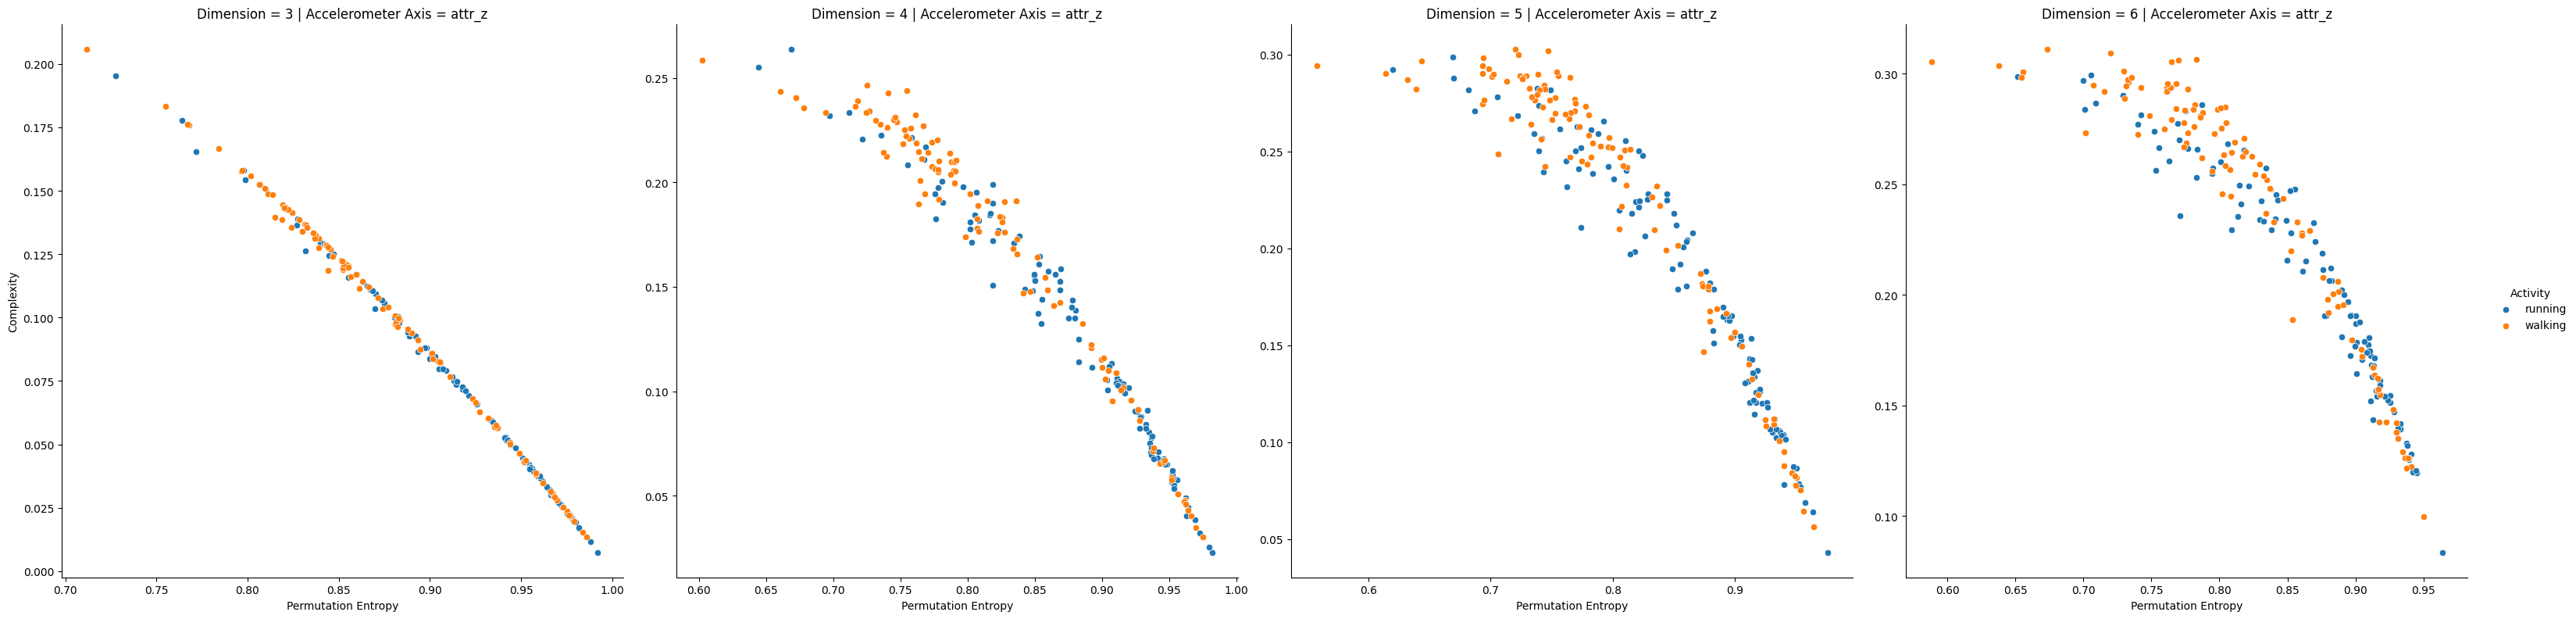

In [69]:
plot_task2_scatterplots(task2_dataframe, ['walking', 'running'], ['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist'])

#####**Optimal Sensor Mounting Positions (Chest & Waist)**

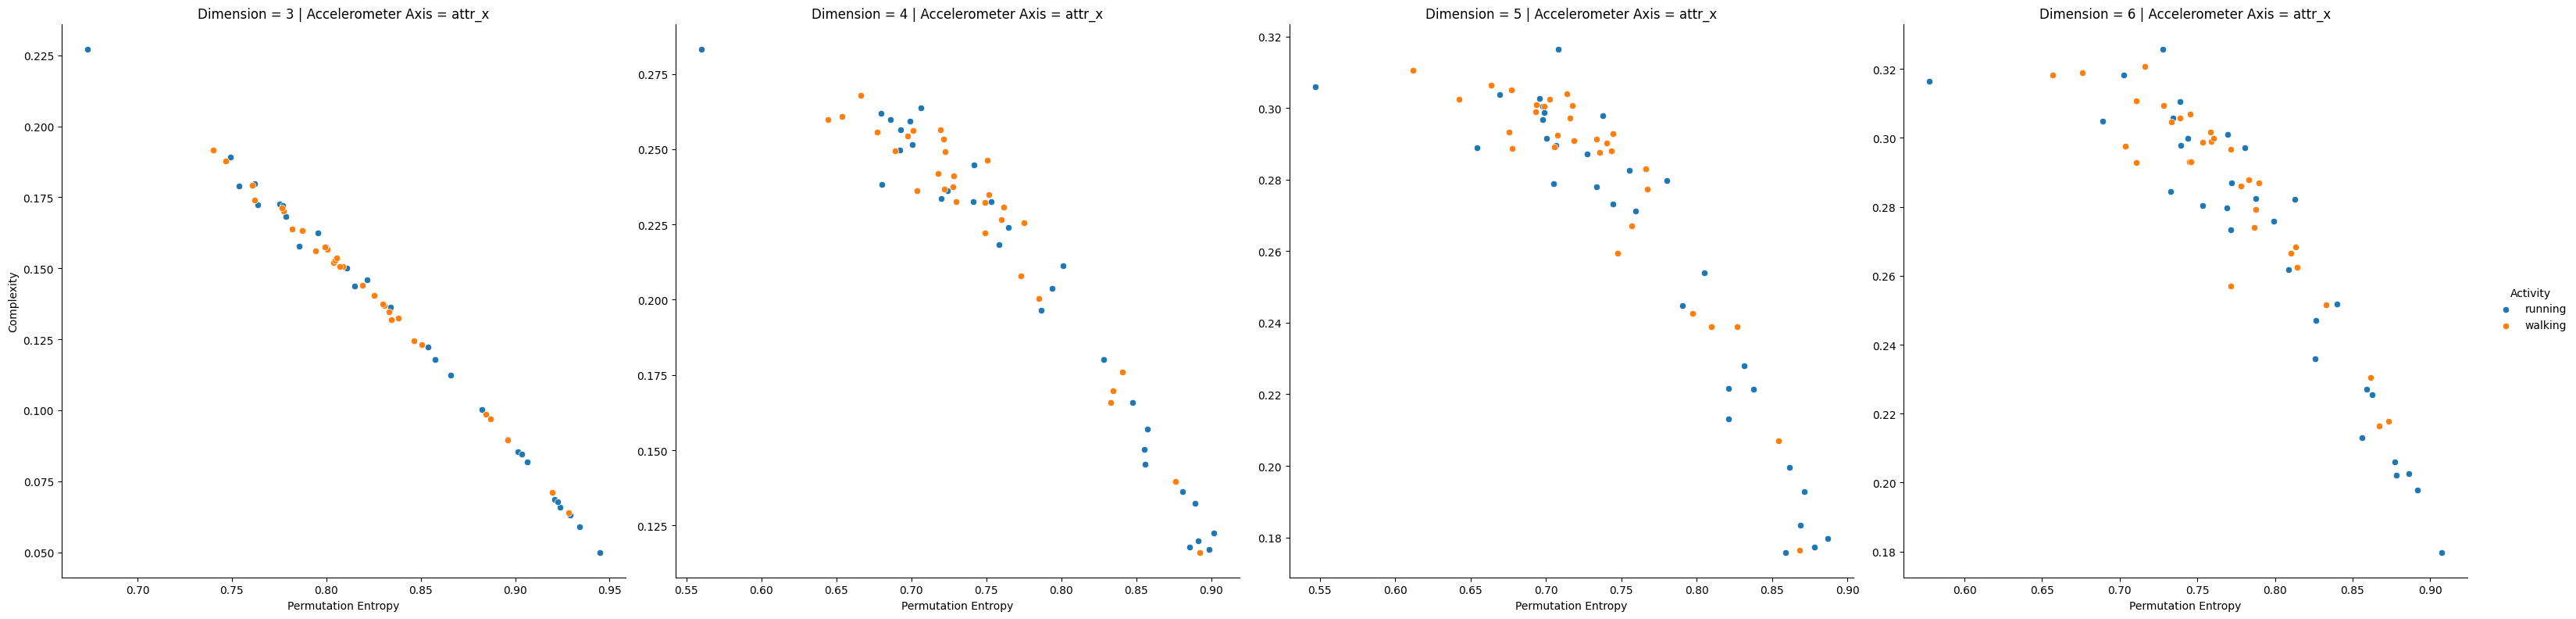

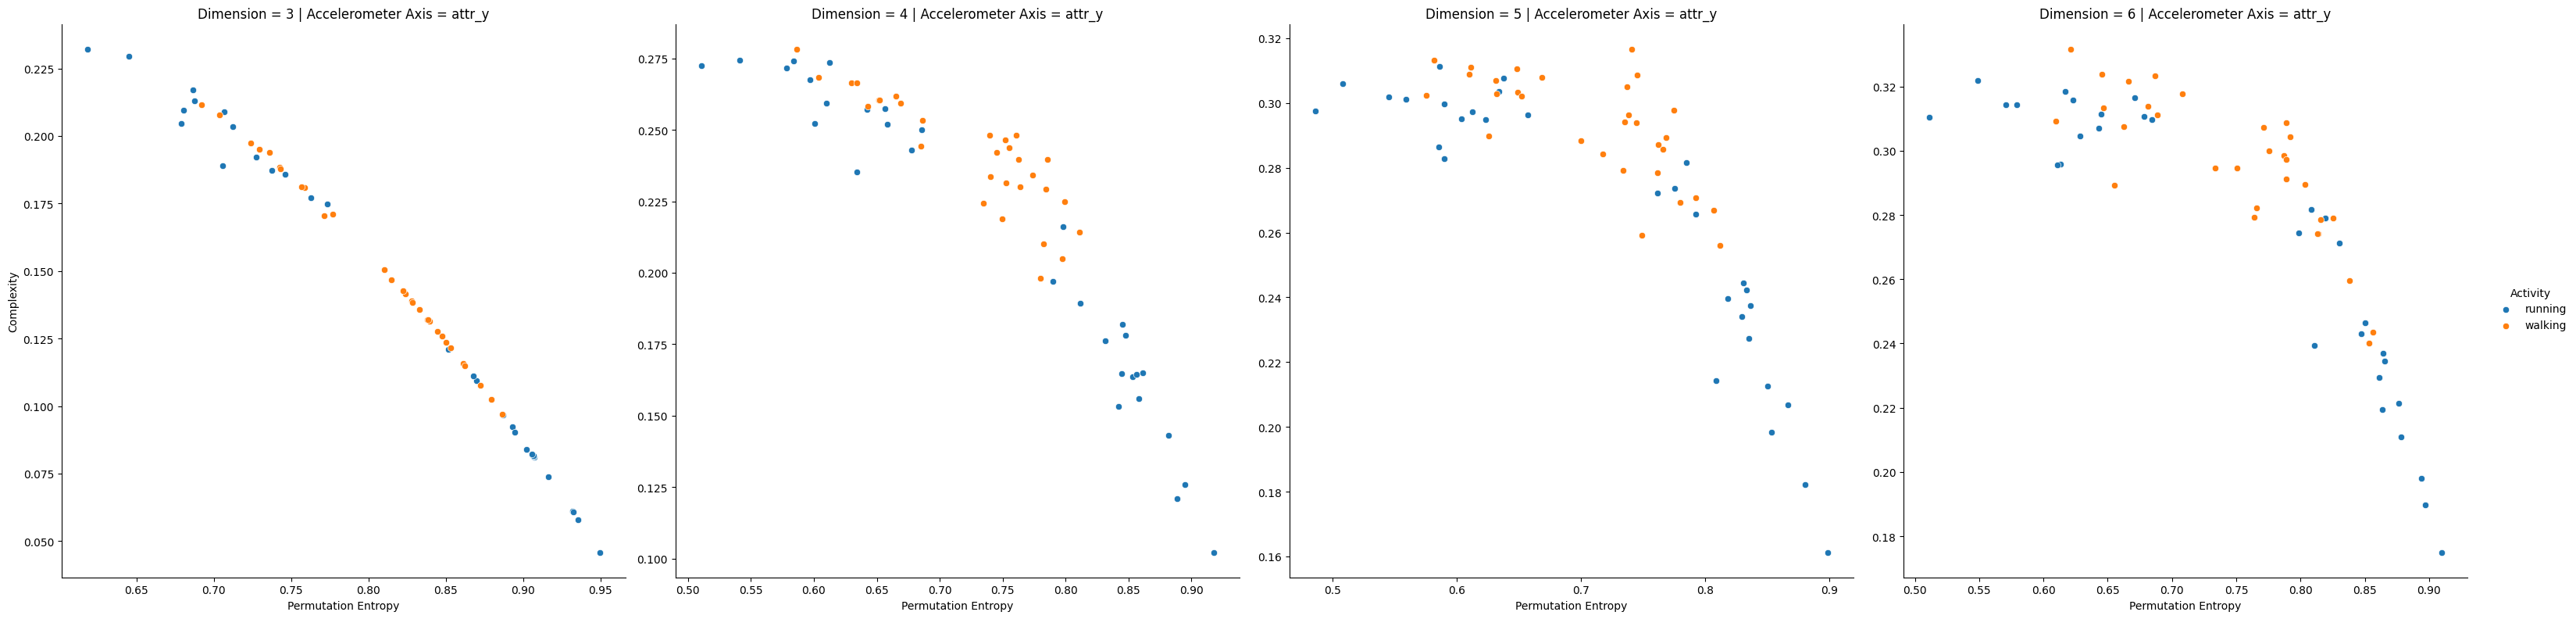

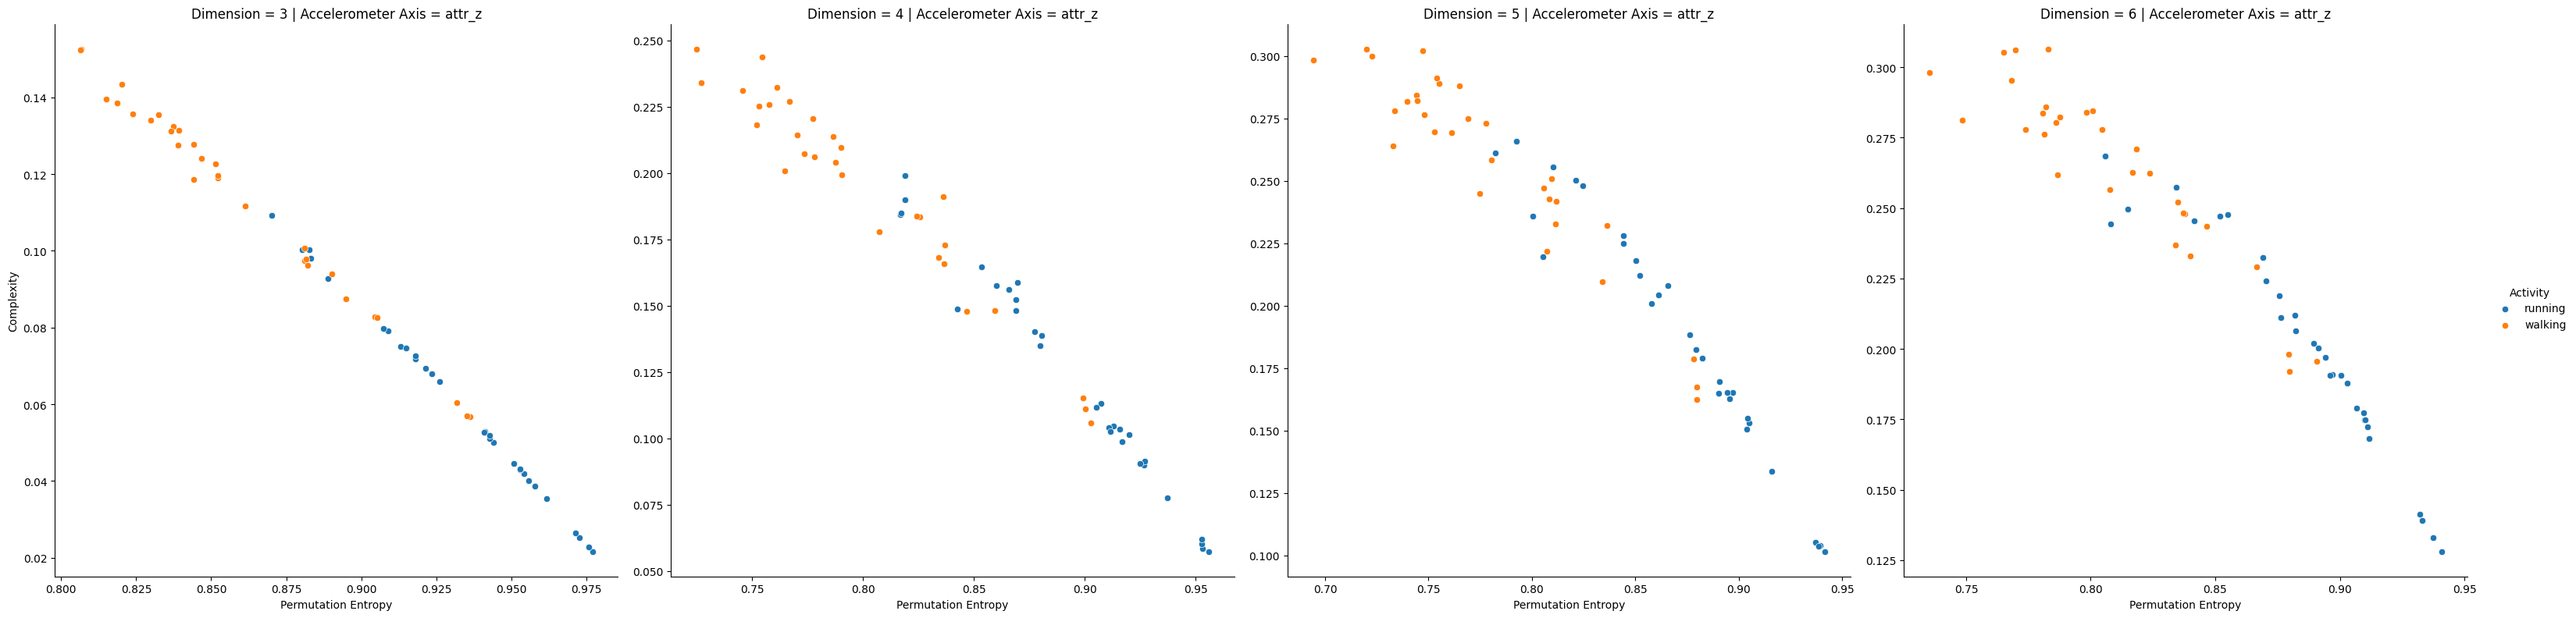

In [70]:
plot_task2_scatterplots(task2_dataframe, ['walking', 'running'], ['chest', 'waist'])

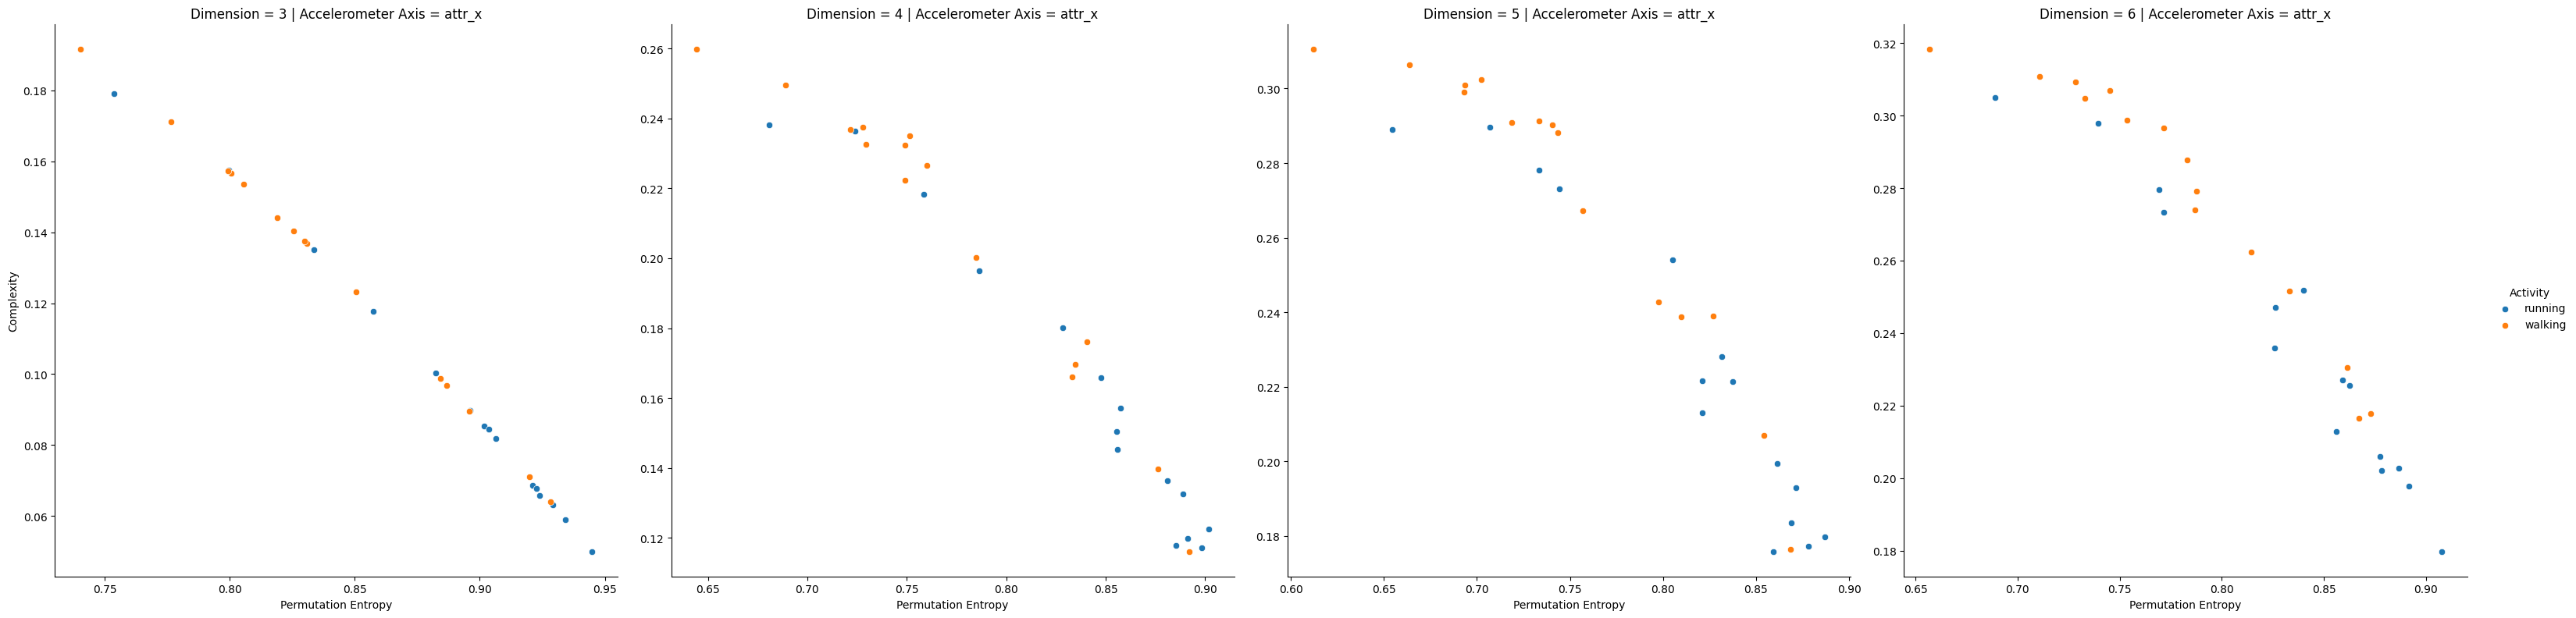

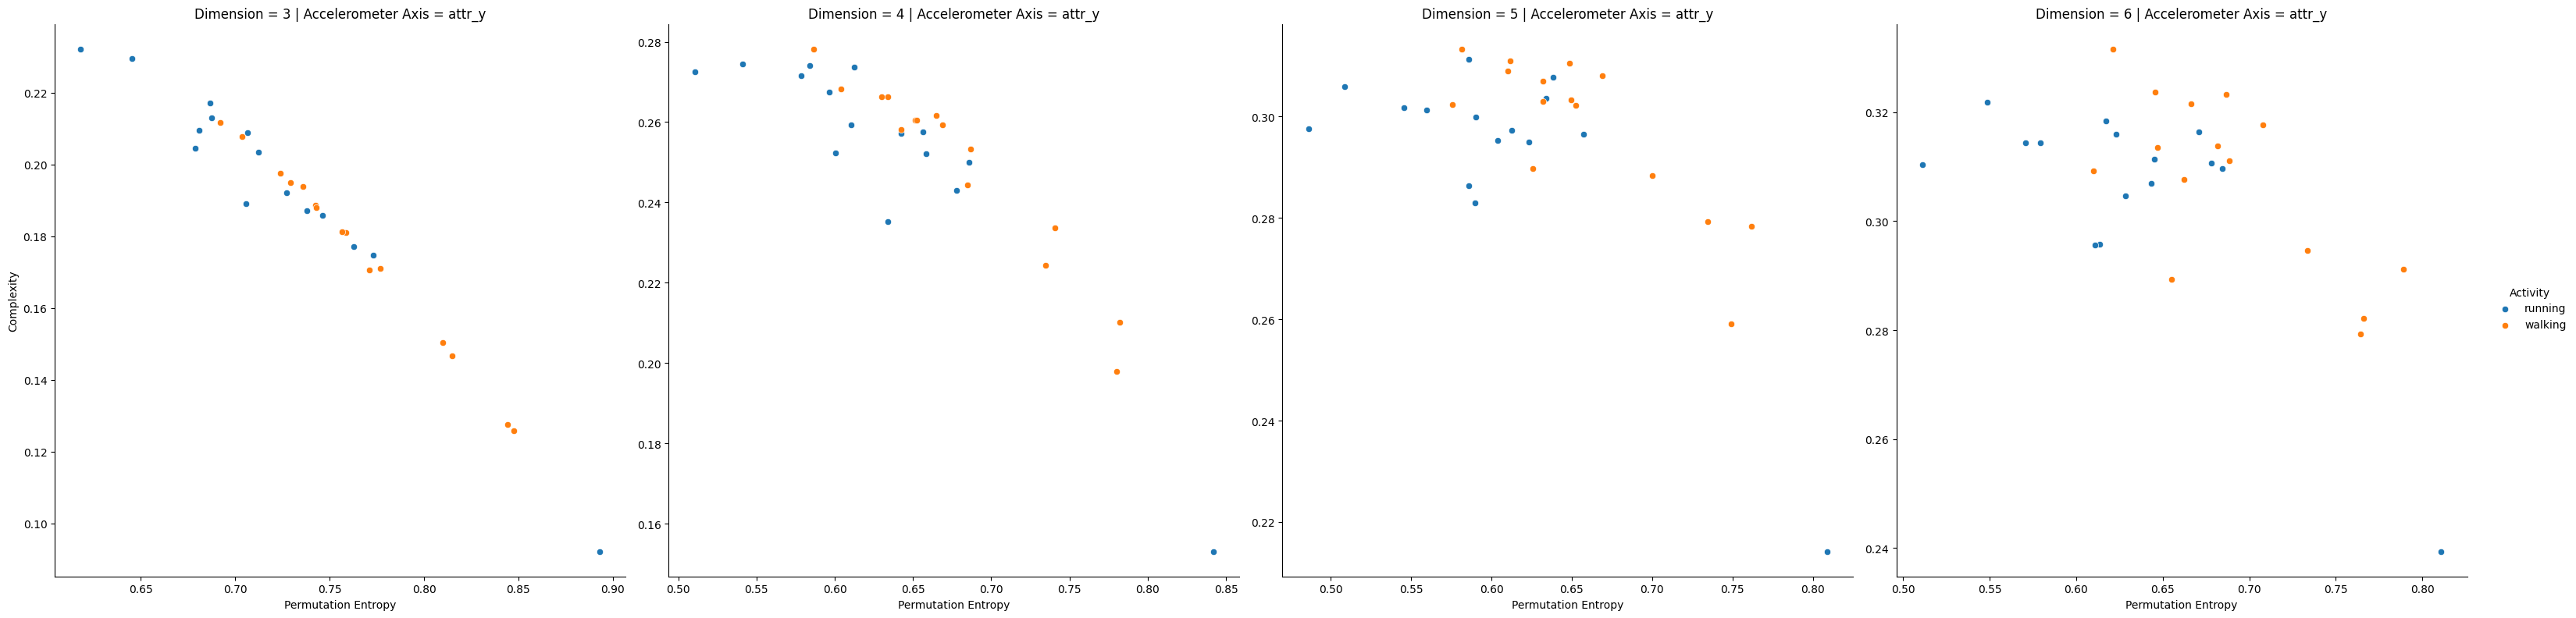

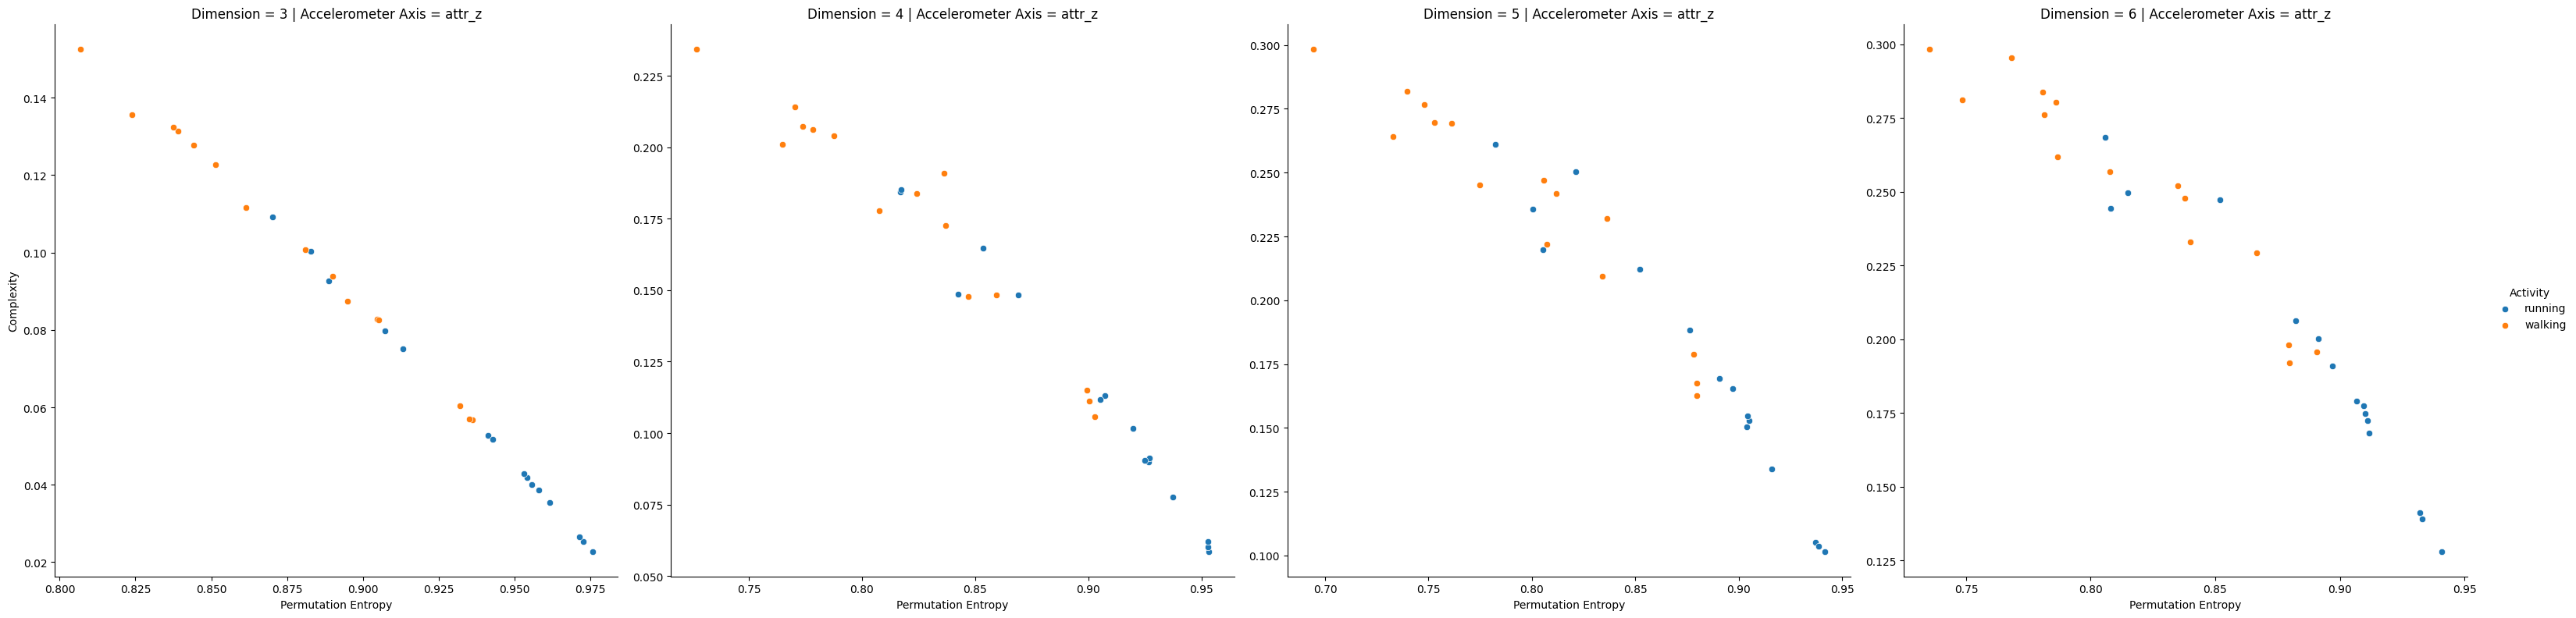

In [71]:
plot_task2_scatterplots(task2_dataframe, ['walking', 'running'], ['chest'])

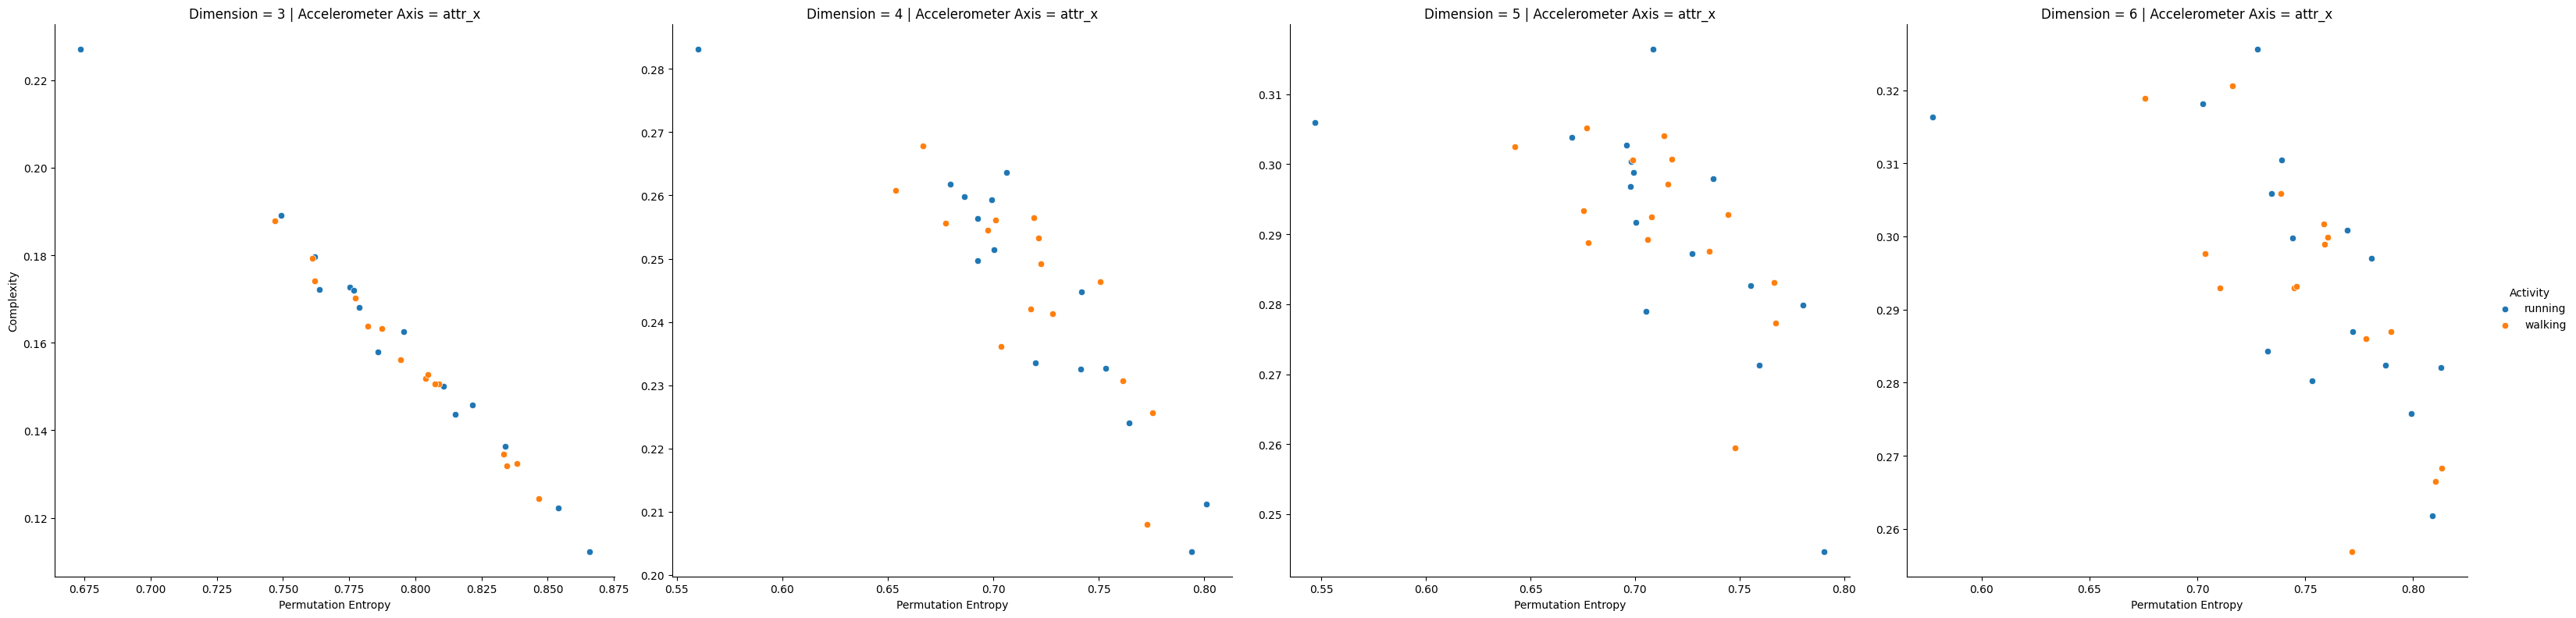

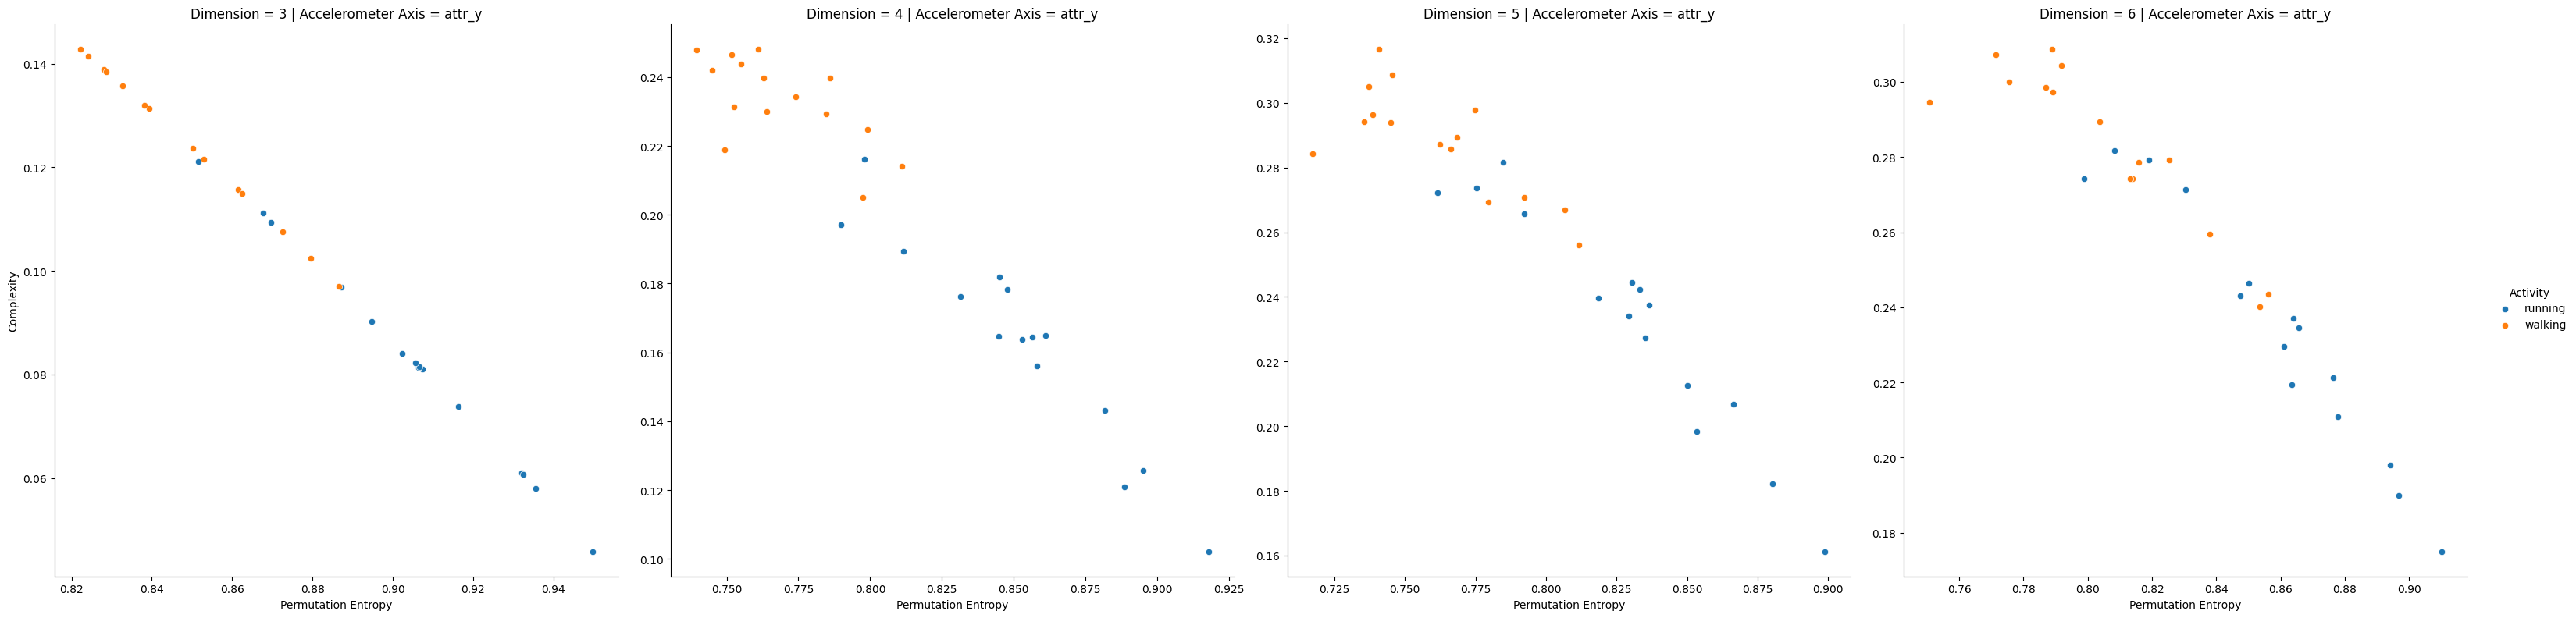

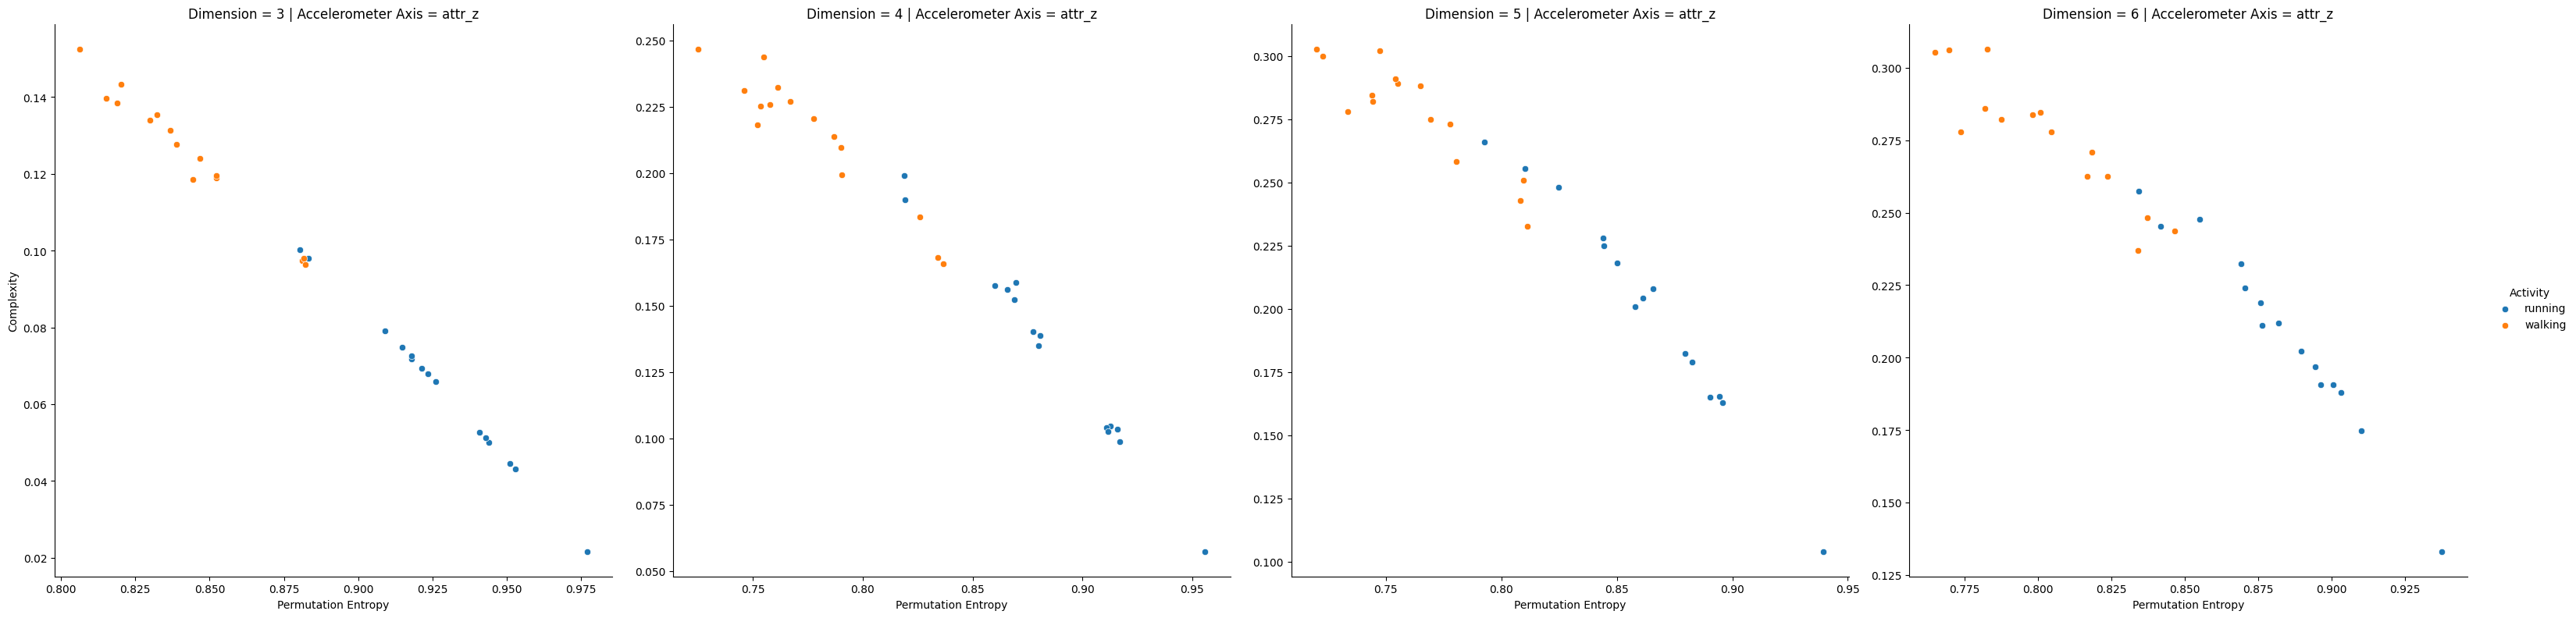

In [72]:
plot_task2_scatterplots(task2_dataframe, ['walking', 'running'], ['waist'])

####**Climbing Up vs Climbing Down**

#####**All Sensor Mounting Positions**

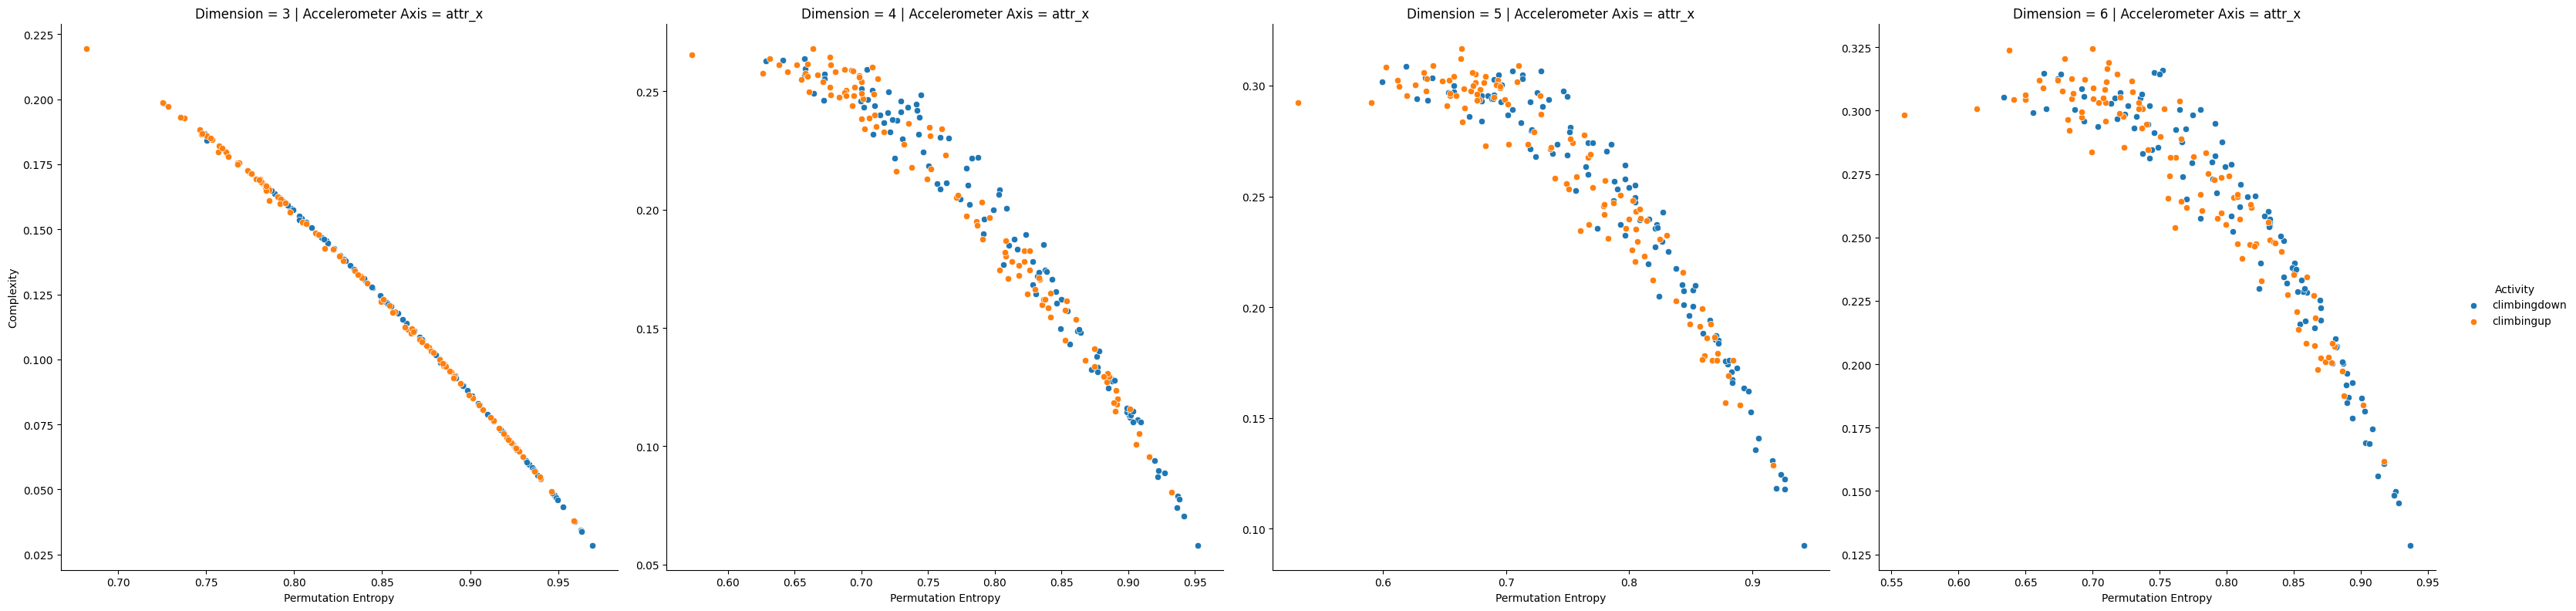

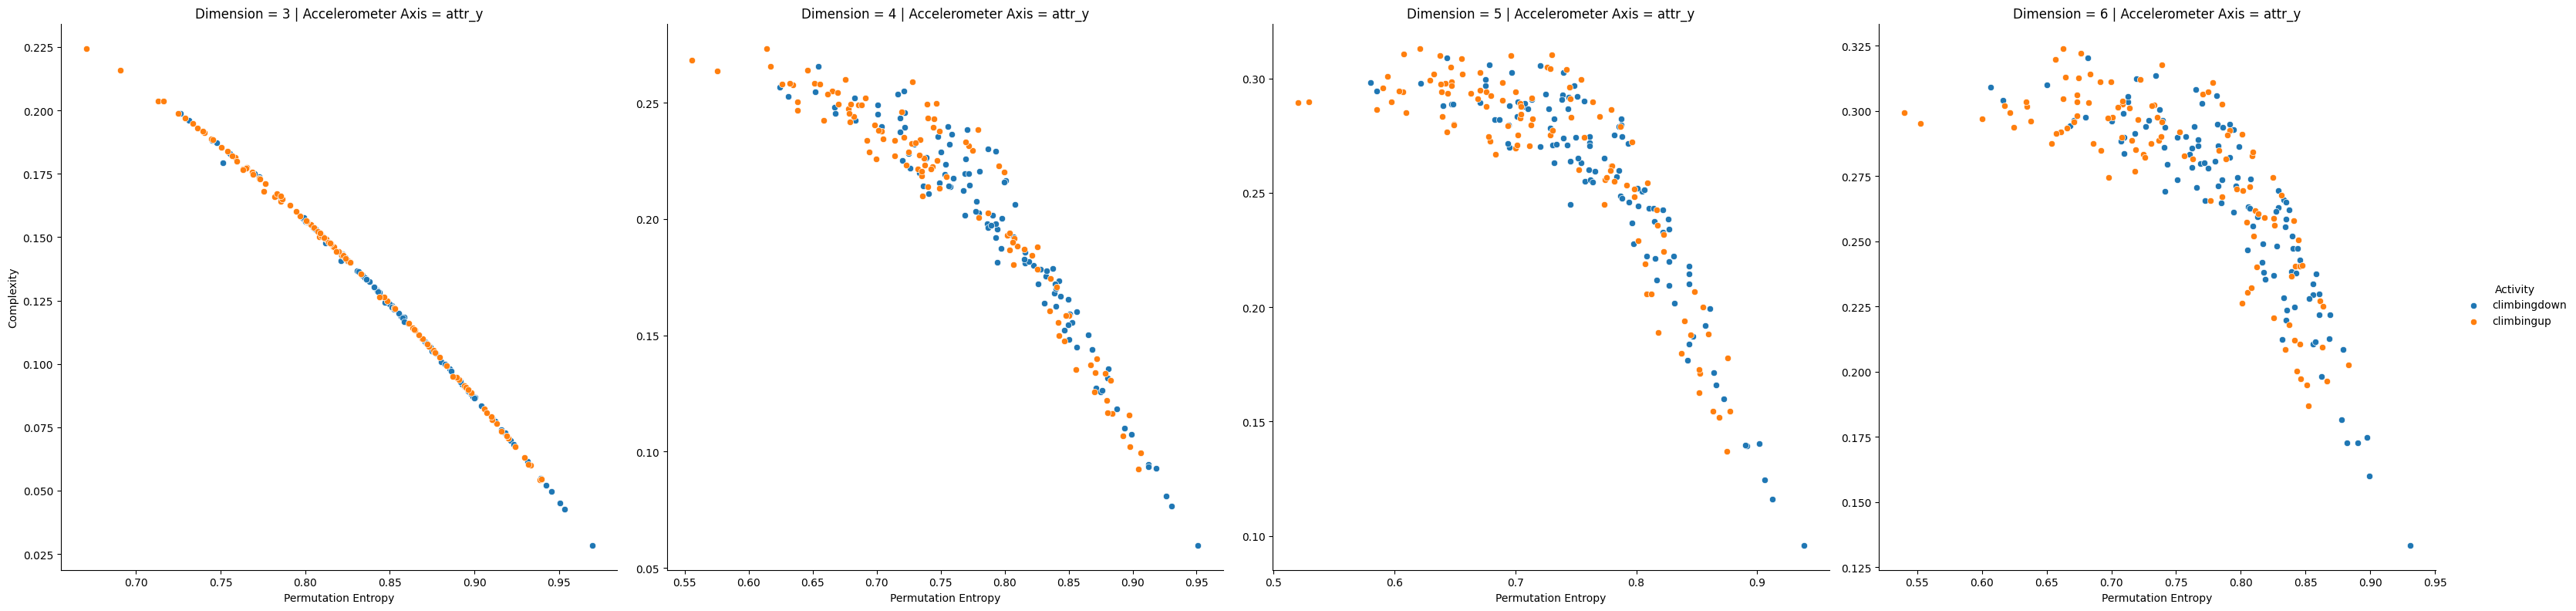

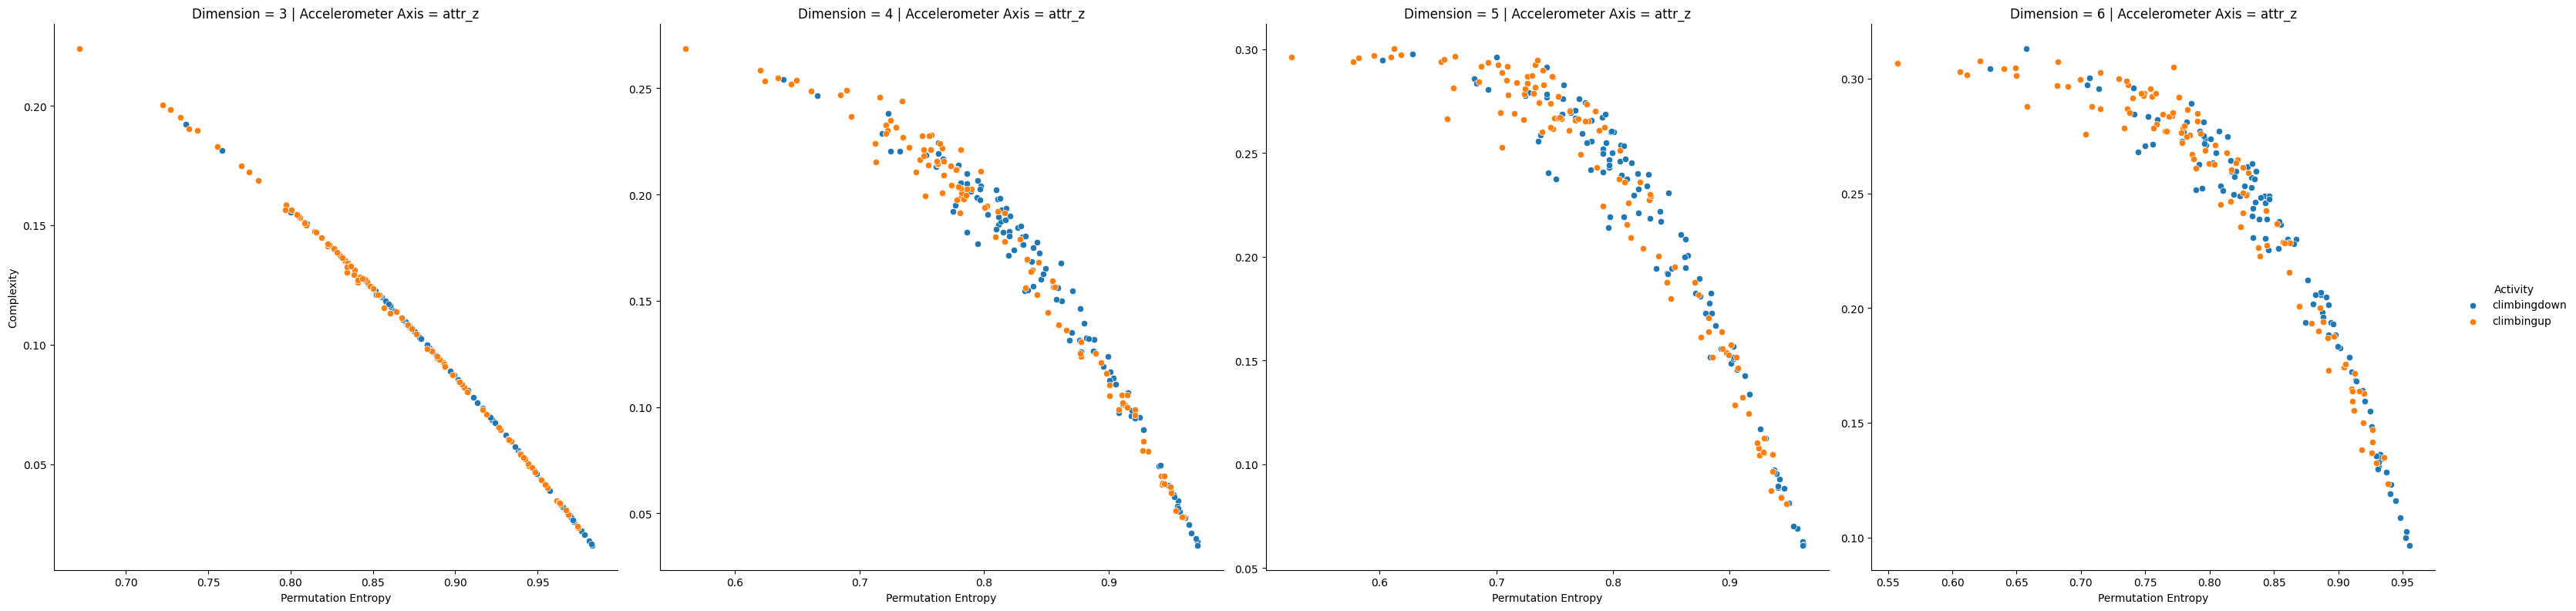

In [73]:
plot_task2_scatterplots(task2_dataframe, ['climbingup', 'climbingdown'], ['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist'])

#####**Optimal Sensor Mounting Positions (Chest & Waist)**

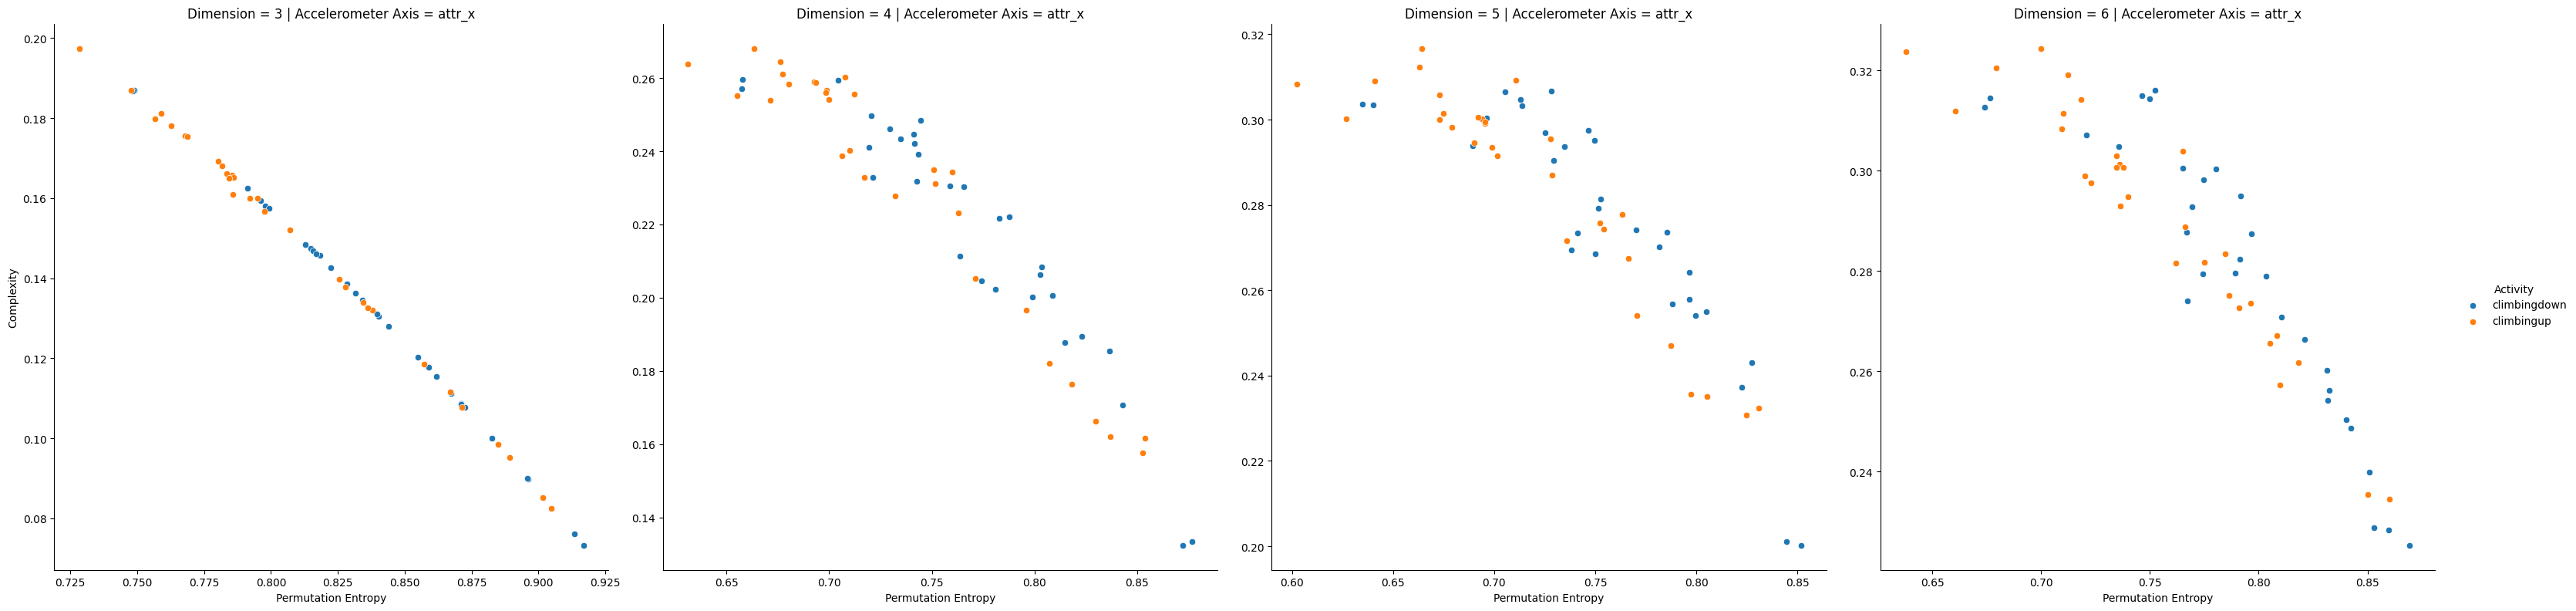

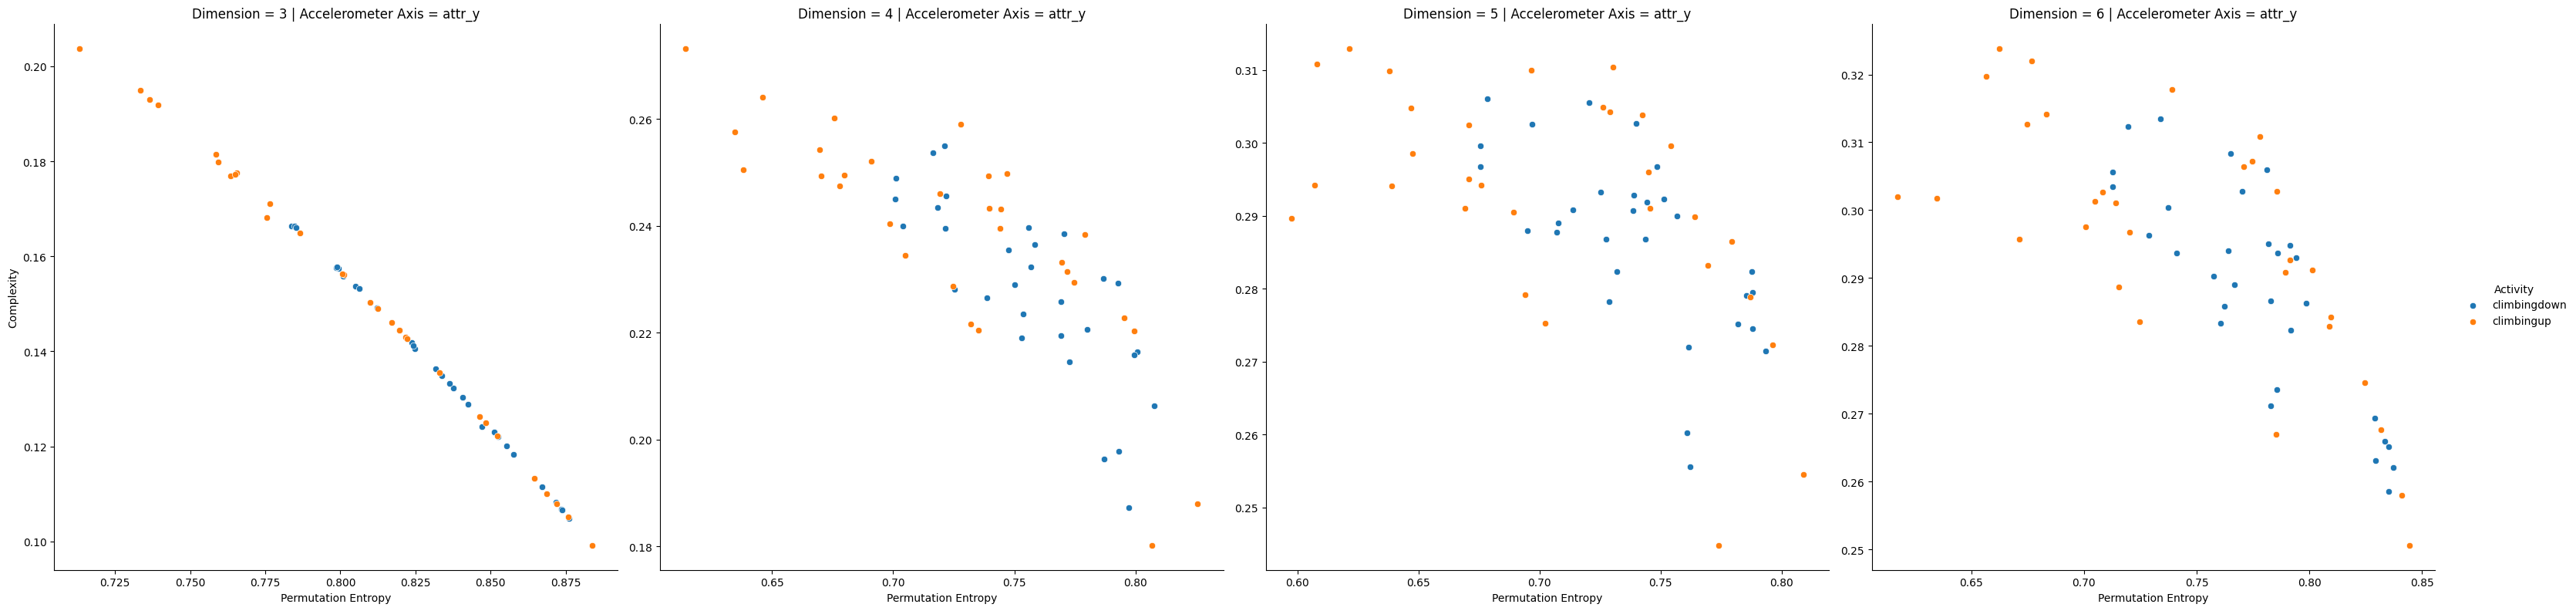

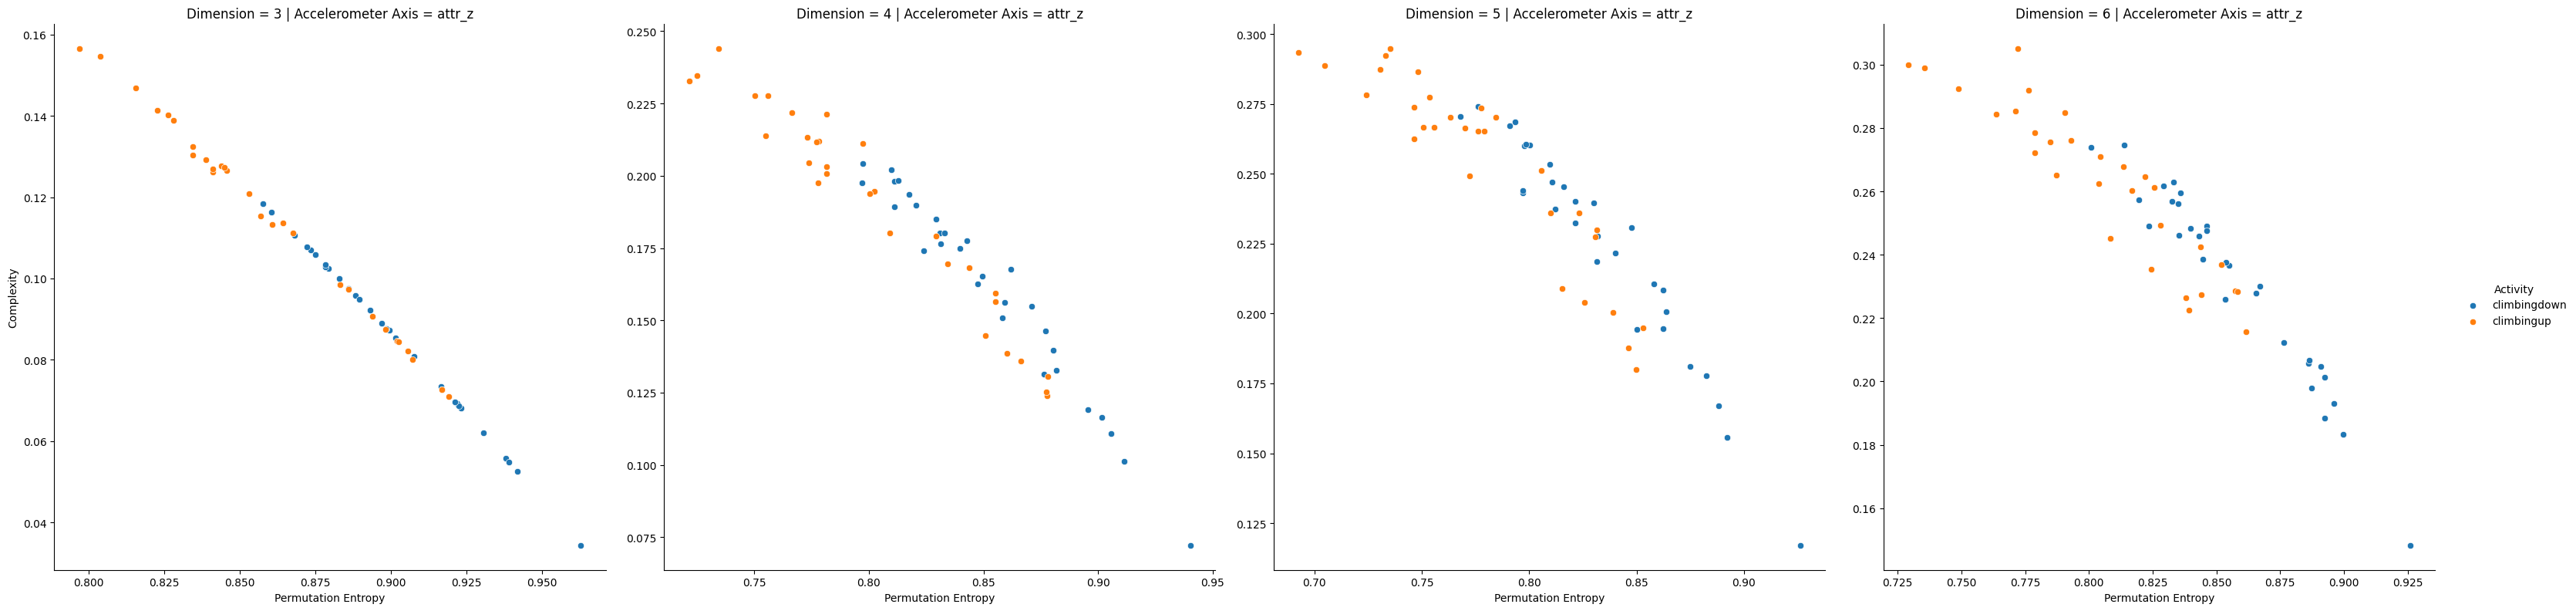

In [74]:
plot_task2_scatterplots(task2_dataframe, ['climbingup', 'climbingdown'], ['chest', 'waist'])

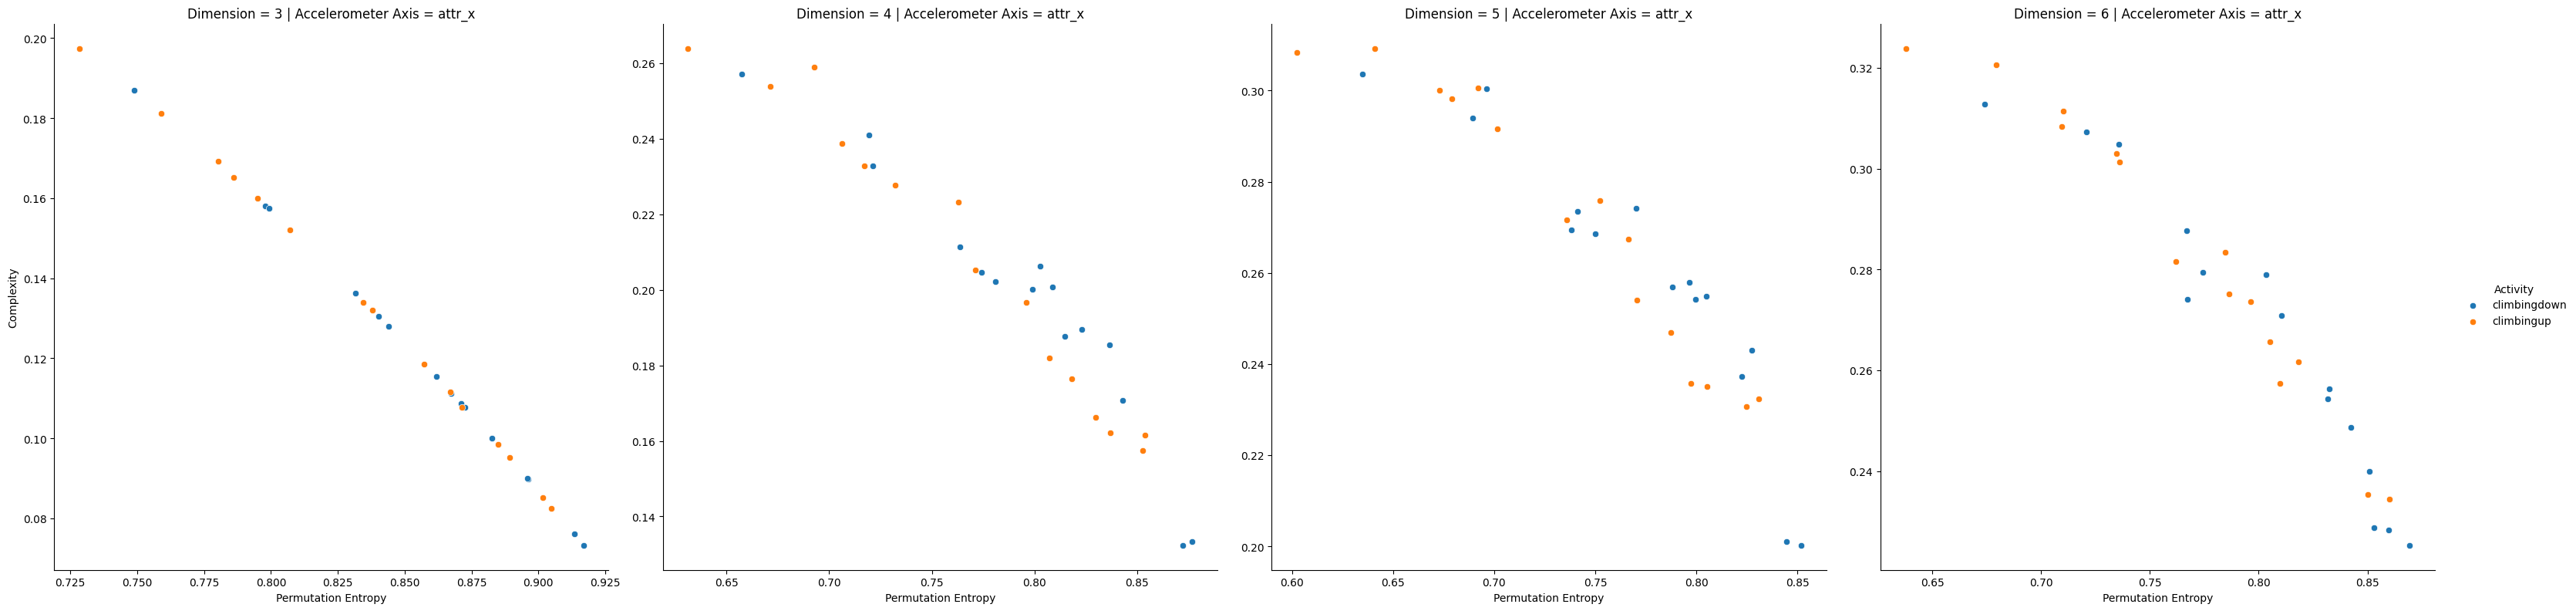

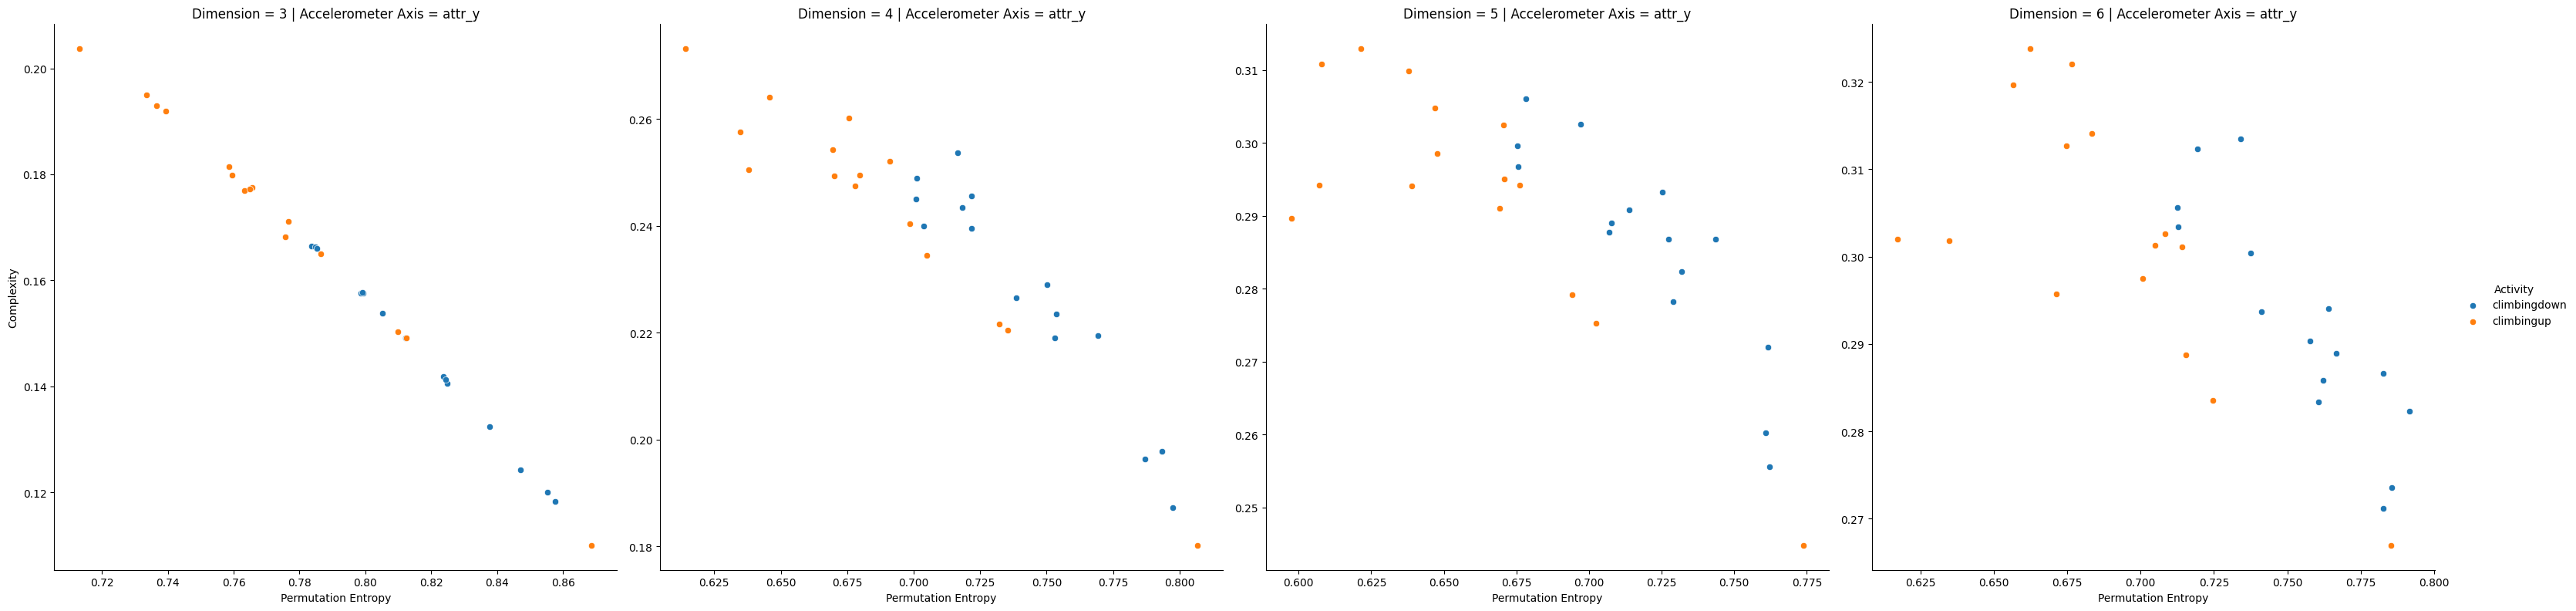

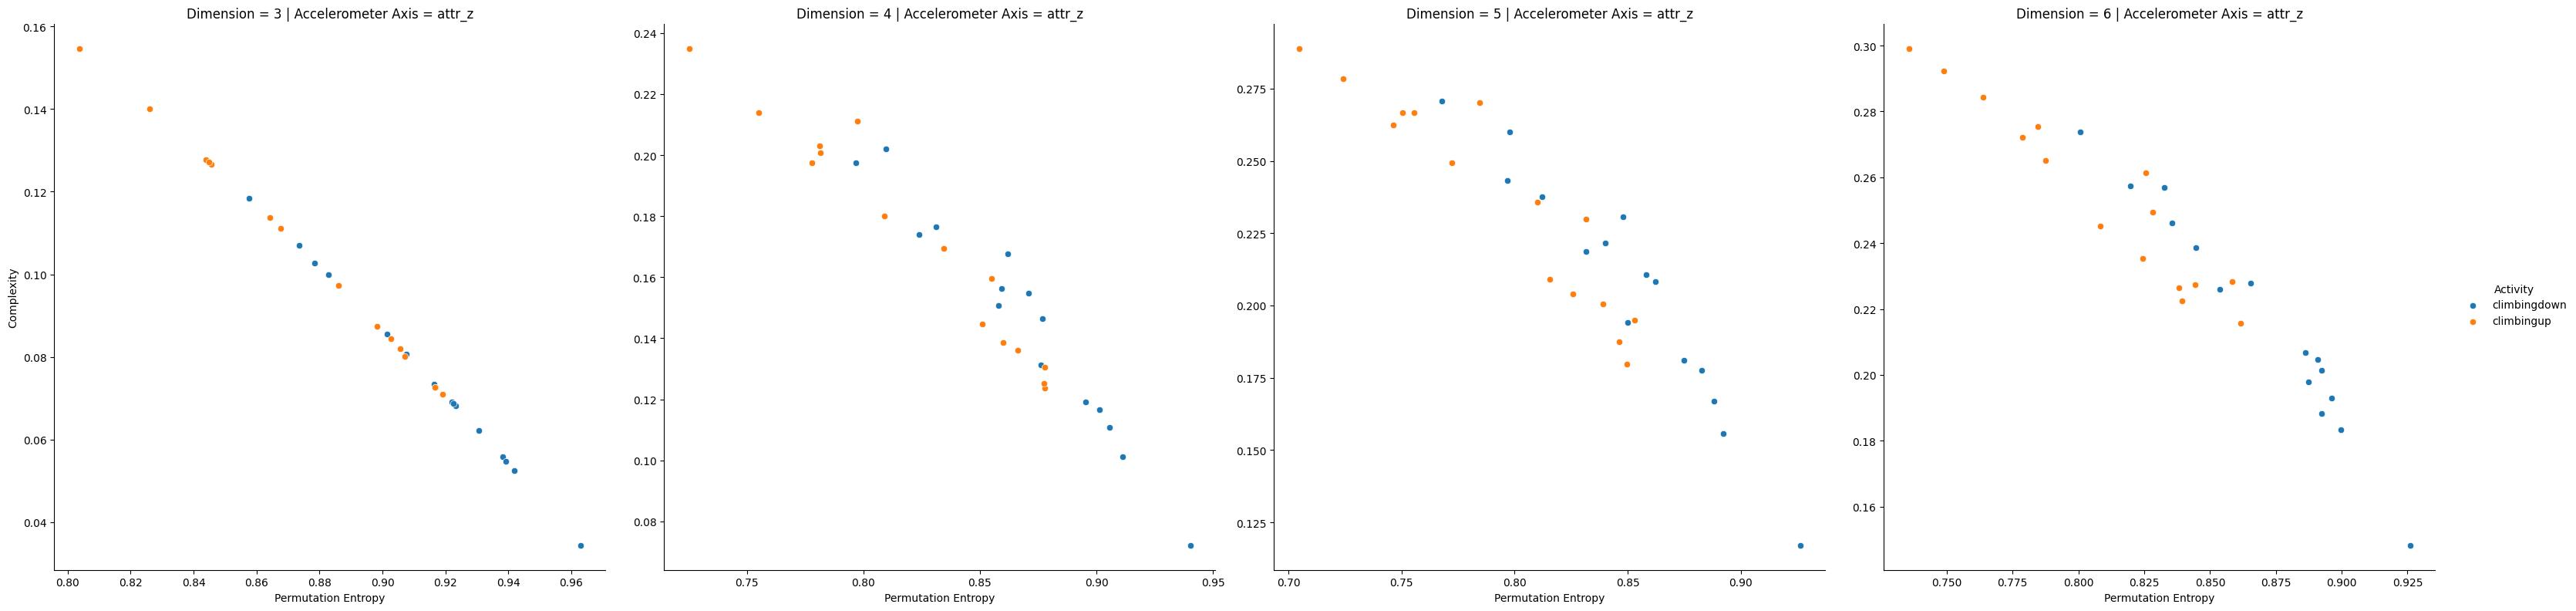

In [75]:
plot_task2_scatterplots(task2_dataframe, ['climbingup', 'climbingdown'], ['chest'])

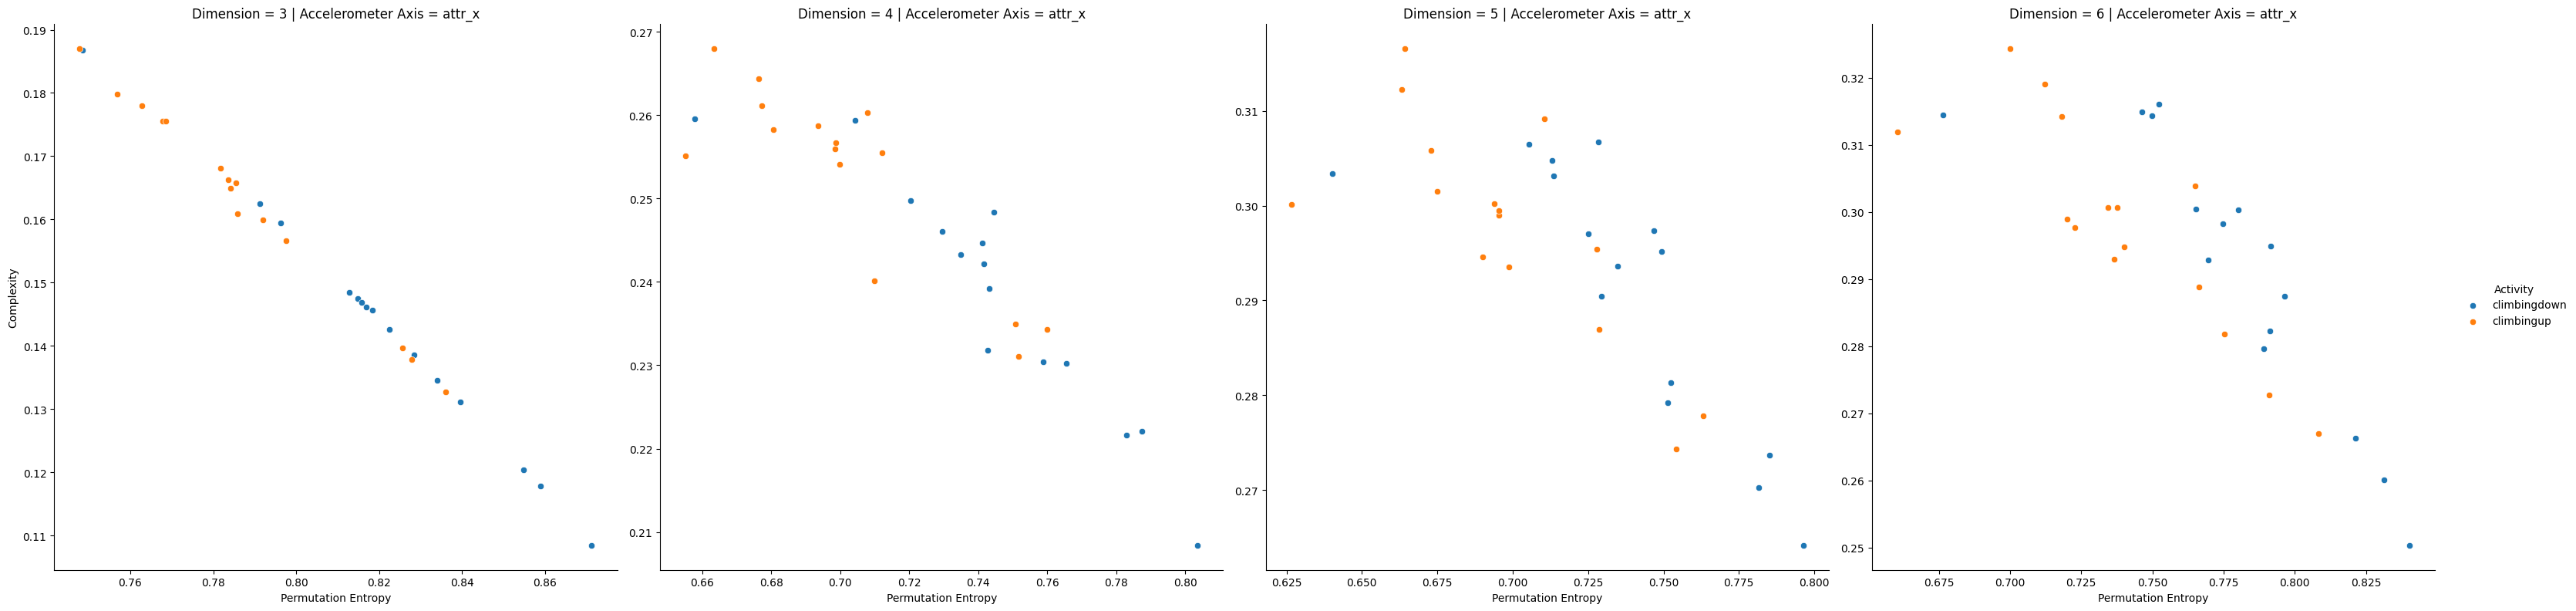

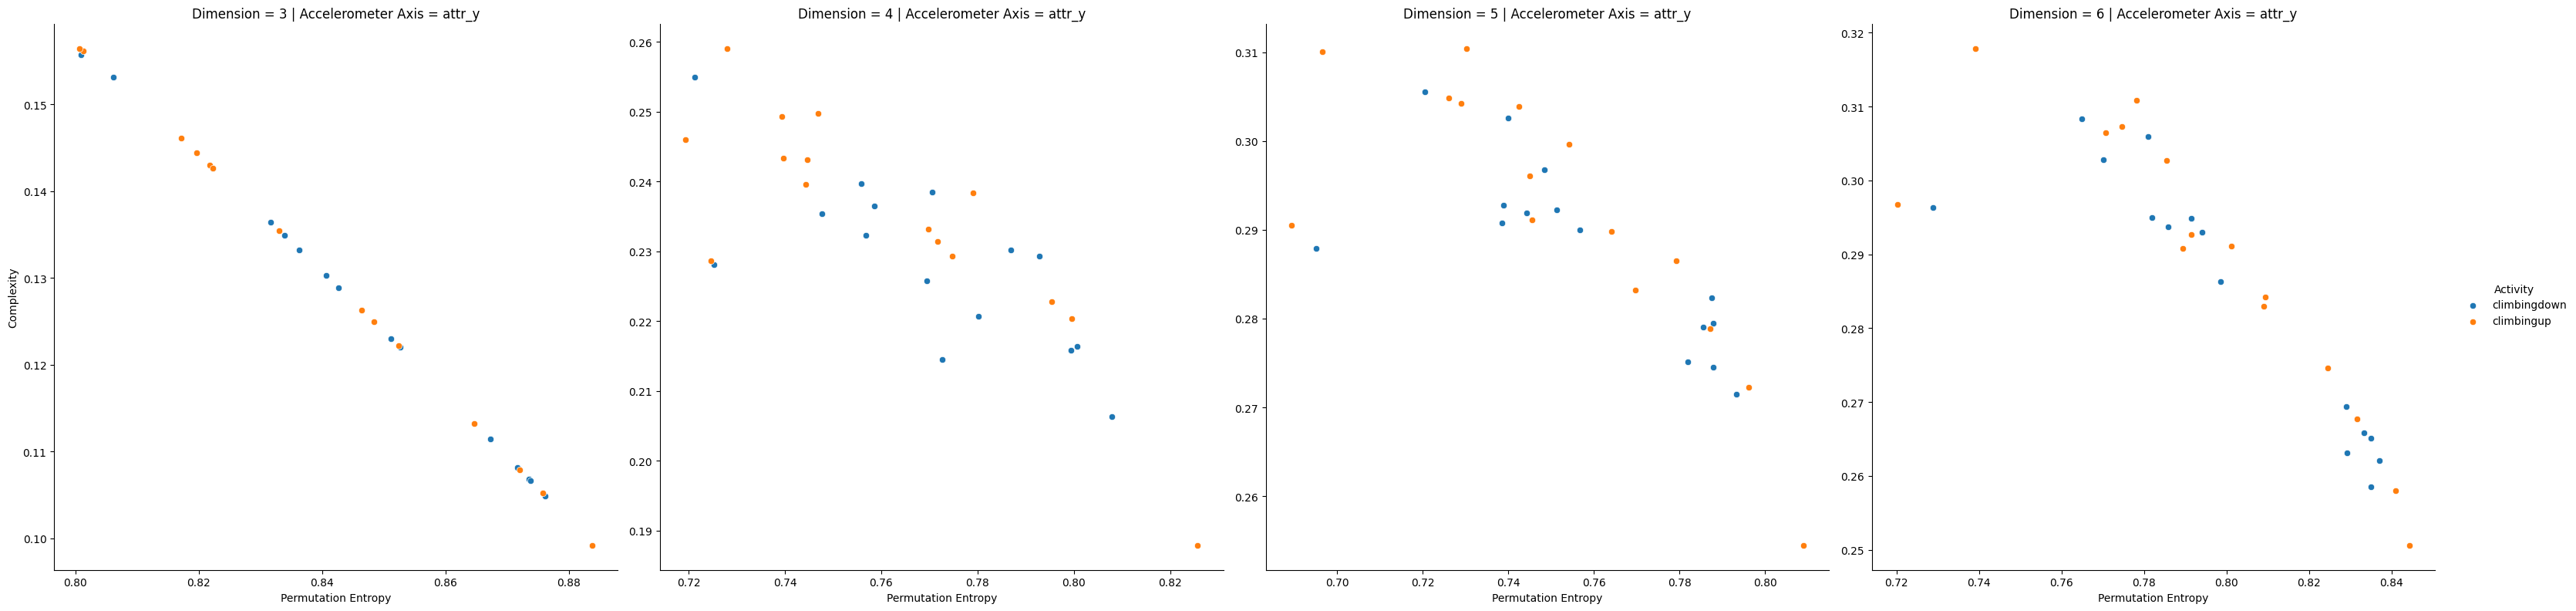

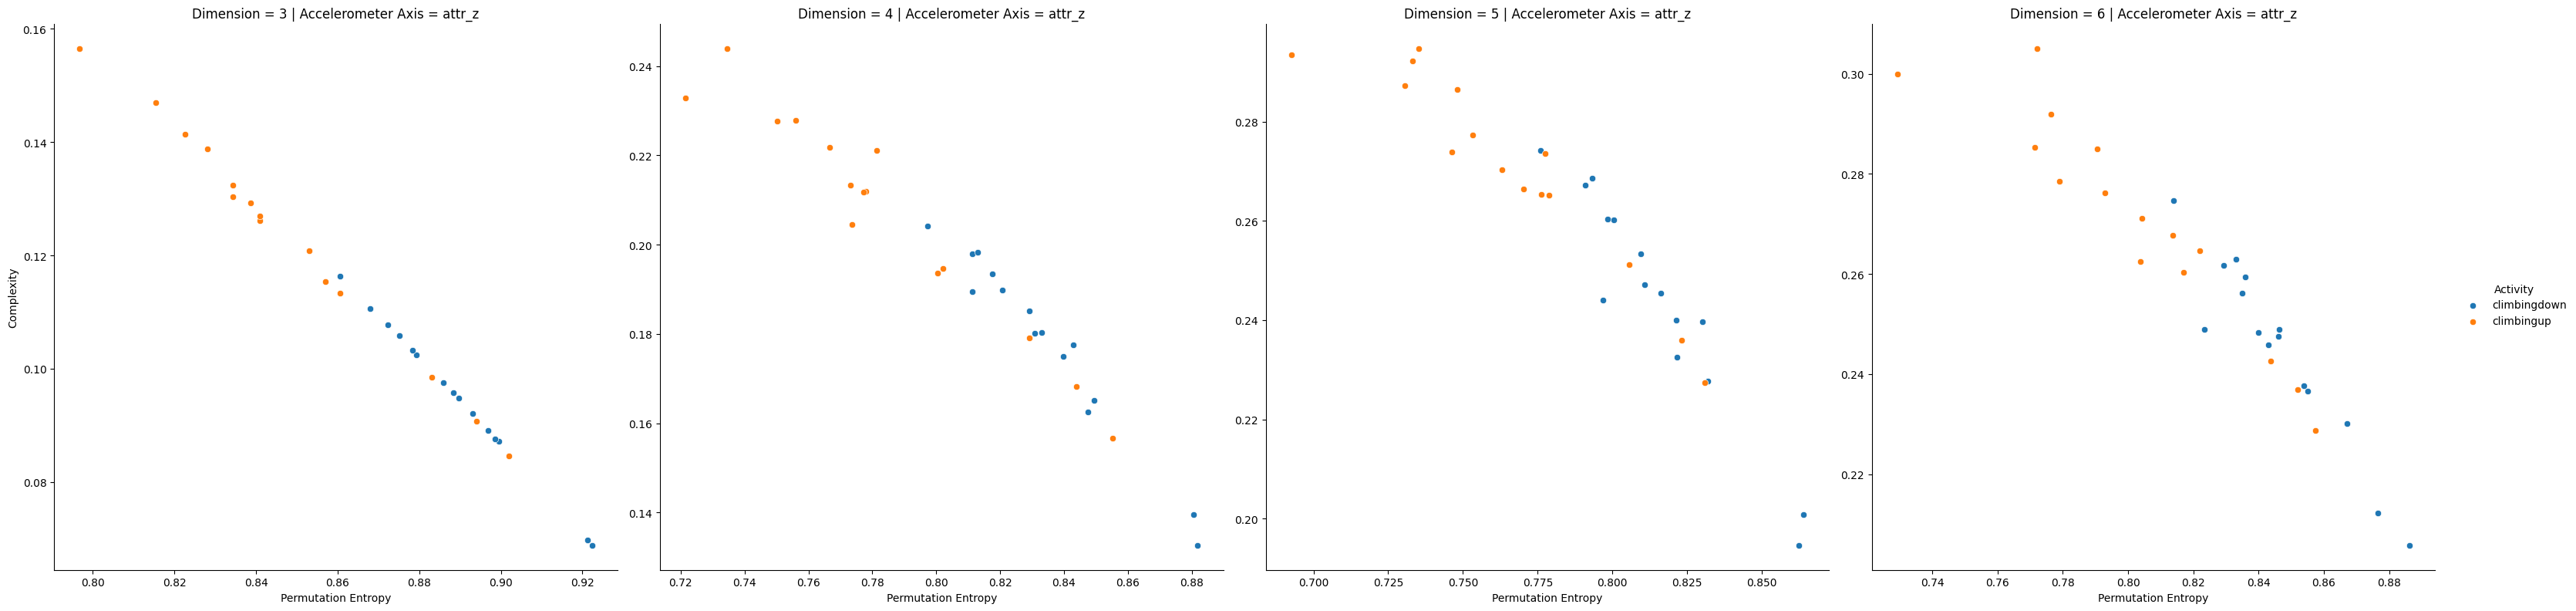

In [76]:
plot_task2_scatterplots(task2_dataframe, ['climbingup', 'climbingdown'], ['waist'])

In [85]:
!jupyter nbconvert --to html IE6400_FDA_Project2_Group8.ipynb

[NbConvertApp] Converting notebook IE6400_FDA_Project2_Group8.ipynb to html
[NbConvertApp] Writing 5789155 bytes to IE6400_FDA_Project2_Group8.html
